# Phase 2 Project version 2.0 - DSC060721 Cohort

Purpose: to adapt prior project notebook for new data

Goal: to use old notebook's code and structure as a baseline for further adjustments



# Selling Seattle: Impactful Features on House Sell Price 

**When selling your house, one of the highest priorities is getting the best price for it.** You may be a real estate agent looking to advise homeowners on the price range for their home, or to give potential buyers an idea of what prices to expect for particular features (like waterfront locations or multiple bedrooms). Or perhaps you are a homeowner who is interested in doing some renovations to improve the house's value. Either way, you want to know what features have the greatest impact on that value.

But how do you *really* know what features are best? How can you be sure that your intuition or expectations are based on fact and not assumptions? **Turn to the facts for answers!**

---

**WHAT QUESTIONS ARE IMPORTANT FROM THE BUSINESS PERSPECTIVE? WHAT QUESTIONS DID I USE TO GUIDE MY EXPLORATION?**

My project used data from house sales in King County, WA. to determine some of the top features determining the sell price of a home.

* **First, I explored the data using the Pandas package to review the data itself.** I reviewed the different features included in my dataset and their respective values; the descriptive statistics for the numerical data; and the overall size and shape of the data (how many rows and columns).

* **Then, I used Seaborn to plot the data and a fitted linear regression model for each feature against the sell price.** These visualizations helped differentiate which features to treat as *categorical* variables (e.g. features that would be one of a select number of options) versus *continuous* variables (which would have less of a rigid range of values).

* **In order to give more depth to my data, I engineered four new features based on the original features and data.** I determined the age of each house at sale; whether or not a home was renovated; how many years since a renovation; and whether or not a house had a basement.

* **I wanted to make sure all of the features and their data were relevant to apply to my future model.** I performed correlational comparisons to determine which features were too closely related (indicating multicollinearity), which would affect my modeling process later on.

* **To test my assumptions that certain features would have a statistically significant impact on the price, I performed a few statistical tests.** I performed an ANOVA test on our "condition" feature (comparing each ranking of condition against the others) and I ran a two-sample t-test on the "waterfront" and "was_renovated" features as well.

* **LReg for Inferences**

# **Setting Up the Tools and Data**

## Imports

In [1]:
# Data Handling
import pandas as pd
import numpy as np
from scipy import stats
import plotly.express as px
import json

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling - Statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sms

# Modeling - SKLearn
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer

# Settings
%matplotlib inline
plt.style.use('seaborn-talk')
pd.set_option('display.max_columns', None)

## Defining Functions

I created several functions to help review, clean, test, and evaluate my data.

### Data Cleaning and Visualizations

> The following functions enable the user to filter a Pandas series and return a boolean index to use for filtering out the outliers. Once saved to a new variable, the user can perform further filtering by using the new variable to slice the dataframe to be filtered.

#### ƒ: `find_outliers_z`

In [2]:
## Check using z-score - sensitive to outliers

def find_outliers_z(data):
    """Detects outliers using the Z-score>3 cutoff.
    Returns a boolean Series where True=outlier
    
    Source: https://github.com/jirvingphd/dsc-phase-2-project/blob/main/functions_SG.py
    """
    
    zFP = np.abs(stats.zscore(data))
    zFP = pd.Series(zFP, index=data.index)
    idx_outliers = zFP > 3
    return idx_outliers

#### ƒ: `find_outliers_IQR`

In [3]:
## Check using IQR - less sensitive to outliers

def find_outliers_IQR(data):
    """
    * Takes a series sliced from a dataframe
    * Detects outliers using the 1.5*IQR thresholds.
    * Returns a boolean Series where True=outlier

    Source: https://github.com/jirvingphd/dsc-phase-2-project/blob/main/functions_SG.py
    """
    
    res = data.describe()
    q1 = res['25%']
    q3 = res['75%']
    thresh = 1.5*(q3-q1)
    idx_outliers =(data < (q1-thresh)) | (data > (q3+thresh))
    return idx_outliers

#### ƒ: `feature_vis`

In [4]:
def feature_vis(data, x, y = 'price', discrete = False, kde = True):
    '''-----
    * Requires a DataFrame and a column name to process.
    * Keyword arguments specify that the target variable will be "price"
    for this case.
    * For future use, redefine function without predetermined y-value, or 
    reassign.
    
    --
    
    * Args:
        * Data: Pandas DataFrame; data source
        * x: str; column index to specify data
    
    * Kwargs:
        * y = "price"
        * discrete = False
        * kde = true
        
    -----'''
    
    ## Print the slice of the original DataFrame for easy viewing
    
    print(df[x].value_counts().sort_index())
  
    ## Create two plots via Seaborn: one scatter plot with regression line,
    ## then a histogram of the data (with KDE if specified
    
    fig, axs = plt.subplots(ncols=2, figsize= (12,6))
    
    sns.regplot(data=data, x=x, y=y, ax=axs[0])
    sns.histplot(data=data, x=x, discrete=discrete, kde=kde, ax=axs[1])
    
    fig.suptitle(f'{x.title()} vs. {y.title()}', fontsize=16)
    plt.tight_layout();
    
    return

#### ƒ: `filter_outliers`

In [5]:
def filter_outliers(data):
    '''------
    
    * Removes outliers from data via "find_outliers_IQR" and saves filtered
    values to the dataframe
    
    ---
    
    * Arg:
        * Data: slice of a dataframe for a specific column header
    
    ------
    '''
   
    idx_out = find_outliers_IQR(data)
 
    cleaned = df[~idx_out]

    print(f'There were {idx_out.sum()} outliers.')
    
    return cleaned

#### ƒ: `remove_outliers`

In [6]:
def remove_outliers(data, x):

    idx_out = find_outliers_IQR(data[x])
 
    df_clean = df[~idx_out].copy()
    
    return df_clean

#### ƒ: `show_cleaned_vis`

In [7]:
def show_cleaned_vis(data, x, y = 'price', discrete = False, kde = True):
    '''-----
    
    * Combines functions to filter outliers and to create the feature 
        visualizations.
    * Requres 'find_outliers_IQR' and 'feature_vis' to be defined.
    * Returns filtered data and two visualizations - Seaborn regression plot
        and histplot.
    
    ---
    
    * Args:
        * Data: Pandas DataFrame; data source
        * x: str; column index to specify data
    * Kwargs
    
    -----'''
    
    ### Filter outliers first
    
    idx_out = find_outliers_IQR(data[x])
 
    df_cleaned = df[~idx_out].copy()

    print(f'There were {idx_out.sum()} outliers.')
    
    ### Plot Data
    
    
    df_cleaned[x].value_counts().sort_index()
        
    fig, axs = plt.subplots(ncols=2, figsize= (12,6))
    
    sns.regplot(data=df_cleaned, x=x, y=y, ax=axs[0],line_kws={"color": "red"})
    sns.histplot(data=df_cleaned, x=x, discrete=discrete, kde=kde, ax=axs[1])
    
    fig.suptitle(f'{x.title()} vs. {y.title()}', fontsize=16)
    plt.tight_layout();
    
    return #df_cleaned

### Creating Function for T-Testing

#### ƒ: `ttest_review`

In [8]:
def ttest_review(sample_1, sample_2, alpha=.05):
    '''------
    * Runs a t-test on two samples; prints whether or not they are significant,
    and returns p-value as a variable called "p-value."
    * Requires two data samples and an alpha value.
    
    ----
    
    * Args: two data samples for t-test
    * Kwargs: alpha=.05
    
    -----
    '''
    
    result = stats.ttest_ind(sample_1, sample_2)
    crit_val, p_val = result
    
    ## Creating interpretation based on p-value results.

    if p_value < .05:
        print(f'The feature "waterfront" is statistically significant with a p-value of {p_val}.')

    else:
         print(f'The feature "waterfront" is not statistically significant with a p-value of {p_val}.')
    
    return p_val

### Creating a Correlation Matrix

#### ƒ: `"corr_val"`

In [9]:
# Create "corr_val" function

def corr_val(df,figsize=(15,15),cmap="OrRd",):
    
    # Calculate correlations
    corr = df.corr()
       
    # Create a mask of the same size as our correlation data
    mask = np.zeros_like(corr)
    
    # Set the upper values of the numpy array to "True" to ignore them
    mask[np.triu_indices_from(mask)] = True

    fig, ax = plt.subplots(figsize=figsize)
    
    # Mask=mask to hide the upper-right half of values (otherwise mirrored)
    sns.heatmap(corr, annot=True,cmap="Reds",mask=mask)
    return fig, ax

### Creating and Evaluating Models

#### ƒ: `create_model`

In [10]:
def create_model(data, cont, cat):
    '''------
    
    * Creates a linear regression model using Statsmodels OLS
    * Save the 
    
    ---
    
    * Args:
        * Data: dataframe as data source
        * Cont: list of continuous variables
        * Cat: list of categorical variables
        * unique_id: UNIQUE name for the resulting model
    
    -----
    '''

    cont_features = '+'.join(cont)

    cat_features = '+'.join([f'C({x})' for x in cat])

    f = f'price~+{cont_features}+{cat_features}'

    print(f)

    model = smf.ols(formula=f, data=data).fit()
   
    diagnose_model(model)
    
    return model

#### ƒ: `diagnose_model`

>* Create a function to:
>  * Display the summary details of the model
>  * Create a scatter plot of the predictions
>    * Used for determining homoscedasticity
>  * Create a Q-Q plot of the residuals of the model
>    * Used to determine the normality of the residuals


In [11]:
def diagnose_model(model, figsize=(10,5)):
    """ ---
    
    Argument:
        * model: provide the linear regression model for diagnostics
    
    Keyword Argument:
        * figsize: default (10,5); can increase/decrease for larger/smaller
    ---
    
    * Display the summary details of the provided model
    * Create two scatter plots to test assumptions of linearity
        * Predictions: verifying homoscedasticity (no cone-shapes)
        * Residuals: confirming normal distribution of residuals
    ---
    
    """
    display(model.summary())
    
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    axes[0].scatter(model.predict(), model.resid)
    axes[0].axhline()
    axes[0].set_xlabel('Model Predictions')
    axes[0].set_ylabel('Model Residuals')
    axes[0].set_title('Testing for Homoscedasticity')

    sms.graphics.qqplot(data=model.resid, fit=True, line = "45", ax=axes[1])
    
    plt.tight_layout()
    
    return

#### ƒ: `plot_param_coef`

>* Create a function to:
>  * Get the model's coefficients as a series
>  * Plot a figure to show the coefficients in descending order


In [12]:
def plot_param_coef(model, kind = 'barh', figsize = (10,5)):
    ''' ---
    
    * Plotting a figure to visualize parameter coefficients
    
    ---
    
    * Args:
        * Model: linear regression model details to plot
        
    * Kwargs:
        * Kind (default 'barh'): allows different types of plots
        * Size (default (10,10)): allows for different sizes
    ---
    
    '''
    # Plotting figure to visualize parameter coefficients

    ## Getting coefficients as a Series
    params = model.params[1:]
    params.sort_values(inplace=True)

    plt.figure(figsize=figsize) # Used if large number of params
    ax = params.plot(kind=kind)
    ax.axvline()
    ax.set_xlabel('Coefficient')
    ax.set_ylabel('Features')
    ax.set_title('Comparing Feature Coefficients')
    
    plt.tight_layout()
    
    return

#### ƒ: `plot_p_values`

In [13]:
def plot_p_values(model, kind = 'barh', size = None, alpha = .05):
    ''' ---
    
    * Plots a figure to visualize parameter p-values exceeding stated alpha.
    
    ---
    
    * Args:
        * Model: linear regression model details to plot
        
    * Kwargs:
        * Kind (default 'barh'): allows different types of plots
        * Size (default None): allows for different sizes
    ---
    
    '''
    
    pv = model.pvalues[1:]
    pv_high = pv[pv > alpha]
    pv_low = pv[pv <= alpha]
    pv_high.sort_values(ascending=False, inplace=True)
    
    if len(pv_high) > 0:
        plt.figure(figsize=size) # Used if large number of params
        ax = pv_high.plot(kind=kind)
        ax = pv_low.plot(kind=kind)
        ax.axvline()
        plt.suptitle(f'P-Values')
        
    if len(pv_low) > 0:
        plt.figure(figsize=size) # Used if large number of params
        ax = pv_low.plot(kind=kind)
        ax.axvline()
        plt.suptitle(f'P-Values Below {alpha}')        
        
#     else:
#         print(f'There are no p-values above {alpha}.')
        
    plt.tight_layout()
    
    return

#### ƒ: `review_model`

In [14]:
def review_model(model):
    '''---
    
    Combines earlier functions into one all-purpose function for reviewing
    model performance.
    
    ---
    
    Arg:
        * model: Specify model to review.
        
    ---'''
    
    diagnose_model(model)
    
    plot_param_coef(model)
    
    plot_p_values(model)
    
    return    

## Reading Data

In [15]:
# old_data = 'https://raw.githubusercontent.com/BenJMcCarty/Phase_2_Project_Final/main/kc_house_data_train.csv'

# new_data = 'https://raw.githubusercontent.com/BenJMcCarty/king_county_housing/main/data/kc_house_data.csv'

offline_data = 'data/kc_house_data.csv'

In [16]:
df= pd.read_csv(offline_data, index_col=0)

# **Exploring Fresh Data**

## Basic Overviews

The goal for this section is to get a broad idea of the data before I start any cleaning or feature engineering.

In [17]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [18]:
## Create dataframe to review the number of unique values, each column's dataype,
## the number of null values, and the percentage of null values in each column

report_df = pd.DataFrame({'num_unique':df.nunique(),
              'DTypes':df.dtypes,
              'NaN_sum':df.isna().sum(),
              'NaN_pct':df.isna().sum()/len(df)})

pd.concat([df.describe().T,report_df], axis=1)

,count,mean,std,min,25%,50%,75%,max,num_unique,DTypes,NaN_sum,NaN_pct
price,21597.0,540296.573506,367368.140101,78000.0000,322000.0000,450000.0000,645000.000,7.700000e+06,3622,float64,0,0.000000
bedrooms,21597.0,3.373200,0.926299,1.0000,3.0000,3.0000,4.000,3.300000e+01,12,int64,0,0.000000
bathrooms,21597.0,2.115826,0.768984,0.5000,1.7500,2.2500,2.500,8.000000e+00,29,float64,0,0.000000
sqft_living,21597.0,2080.321850,918.106125,370.0000,1430.0000,1910.0000,2550.000,1.354000e+04,1034,int64,0,0.000000
sqft_lot,21597.0,15099.408760,41412.636876,520.0000,5040.0000,7618.0000,10685.000,1.651359e+06,9776,int64,0,0.000000
floors,21597.0,1.494096,0.539683,1.0000,1.0000,1.5000,2.000,3.500000e+00,6,float64,0,0.000000
waterfront,19221.0,0.007596,0.086825,0.0000,0.0000,0.0000,0.000,1.000000e+00,2,float64,2376,0.110015
view,21534.0,0.233863,0.765686,0.0000,0.0000,0.0000,0.000,4.000000e+00,5,float64,63,0.002917
condition,21597.0,3.409825,0.650546,1.0000,3.0000,3.0000,4.000,5.000000e+00,5,int64,0,0.000000
grade,21597.0,7.657915,1.173200,3.0000,7.0000,7.0000,8.000,1.300000e+01,11,int64,0,0.000000


## Data Cleaning and Processing

**DF Columns to Convert**

* 'date' to datetime; continuous variable
* 'waterfront' to category; discrete/categorical variable
* 'view' to category; discrete/categorical
* 'condition' to category; discrete/categorical variable
* 'grade' to category; discrete/categorical variable
* 'zipcode' to category; discrete/categorical variable

**Null Values to Process**
* 'yr_renovated'
    - check against yr_built; if diff == 0, then fill with zero
    - If diff > 0, determine h2 fillna
* 'waterfront' - ColXF, KNN/ItImp
* 'view' - ColXF, KNN/ItImp

In [19]:
## Converting 'date' column to datetime

df['date'] = pd.to_datetime(df['date'])
df['date']

id
7129300520   2014-10-13
6414100192   2014-12-09
5631500400   2015-02-25
2487200875   2014-12-09
1954400510   2015-02-18
                ...    
263000018    2014-05-21
6600060120   2015-02-23
1523300141   2014-06-23
291310100    2015-01-16
1523300157   2014-10-15
Name: date, Length: 21597, dtype: datetime64[ns]

In [20]:
## Converting 'sqft_basement' to numeric and filling any null values with zero
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'], errors='coerce')
df['sqft_basement'].fillna('0', inplace=True)
print(f'There are {df["sqft_basement"].isna().sum()} null values.\n')
df['sqft_basement'].value_counts()

There are 0 null values.



0.0       12826
0           454
600.0       217
500.0       209
700.0       208
          ...  
666.0         1
1930.0        1
1920.0        1
1913.0        1
3500.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [21]:
df['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [22]:
report_df = pd.DataFrame({'num_unique':df.nunique(),
              'DTypes':df.dtypes,
              'NaN_sum':df.isna().sum(),
              'NaN_pct':df.isna().sum()/len(df)})

pd.concat([df.describe().T,report_df], axis=1)

,count,mean,std,min,25%,50%,75%,max,num_unique,DTypes,NaN_sum,NaN_pct
price,21597.0,540296.573506,367368.140101,78000.0000,322000.0000,450000.0000,645000.000,7.700000e+06,3622,float64,0,0.000000
bedrooms,21597.0,3.373200,0.926299,1.0000,3.0000,3.0000,4.000,3.300000e+01,12,int64,0,0.000000
bathrooms,21597.0,2.115826,0.768984,0.5000,1.7500,2.2500,2.500,8.000000e+00,29,float64,0,0.000000
sqft_living,21597.0,2080.321850,918.106125,370.0000,1430.0000,1910.0000,2550.000,1.354000e+04,1034,int64,0,0.000000
sqft_lot,21597.0,15099.408760,41412.636876,520.0000,5040.0000,7618.0000,10685.000,1.651359e+06,9776,int64,0,0.000000
floors,21597.0,1.494096,0.539683,1.0000,1.0000,1.5000,2.000,3.500000e+00,6,float64,0,0.000000
waterfront,19221.0,0.007596,0.086825,0.0000,0.0000,0.0000,0.000,1.000000e+00,2,float64,2376,0.110015
view,21534.0,0.233863,0.765686,0.0000,0.0000,0.0000,0.000,4.000000e+00,5,float64,63,0.002917
condition,21597.0,3.409825,0.650546,1.0000,3.0000,3.0000,4.000,5.000000e+00,5,int64,0,0.000000
grade,21597.0,7.657915,1.173200,3.0000,7.0000,7.0000,8.000,1.300000e+01,11,int64,0,0.000000


In [23]:
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'], errors='coerce')

In [24]:
df_na_col = []
for col in df:
    if df[col].isna().sum() > 0:
        df_na_col.append(col)

df_na_col

['waterfront', 'view', 'yr_renovated']

In [25]:
for i in df_na_col:
    df[i].fillna(df[i].mode()[0], inplace=True)

In [26]:
# from sklearn.compose import ColumnTransformer

# ct = ColumnTransformer([('imp_mode',estimators = ('sim_imp', SimpleImputer), 'waterfront')], 
#                   remainder='passthrough',n_jobs = -1)

# ct.fit_transform(df)

In [27]:
report_df = pd.DataFrame({'num_unique':df.nunique(),
              'DTypes':df.dtypes,
              'NaN_sum':df.isna().sum(),
              'NaN_pct':df.isna().sum()/len(df)})

report_df

,num_unique,DTypes,NaN_sum,NaN_pct
date,372,datetime64[ns],0,0.0
price,3622,float64,0,0.0
bedrooms,12,int64,0,0.0
bathrooms,29,float64,0,0.0
sqft_living,1034,int64,0,0.0
sqft_lot,9776,int64,0,0.0
floors,6,float64,0,0.0
waterfront,2,float64,0,0.0
view,5,float64,0,0.0
condition,5,int64,0,0.0


### Overview Summary

The dataset contains 21 colums of data, most of which seem useful for evaluations and modeling, but "id" and "date" are not really usable in their current state.

I do not have any null values to handle. Additionally, the data types seem to be relatively accurate; the only exception being the dates being treated as an object vs. datetime.

I could convert the date for later calculations, engineering, or modeling. For now, I will leave it as-is.

## Exploring Features

Now I will be comparing each individual feature against "price" to determine if a feature is continuous or categorical.

I will check the regressions and histograms for each feature; if a regression plot shows a flatter regression line or if the histogram is not a normal distribution, I will treat that feature as a categorical feature.

As part of the function to create the plots, I include my function to ignore any outliers for the purpose of the visualizations. I will *not* change the data itself, though.

### Bedrooms

There were 530 outliers.


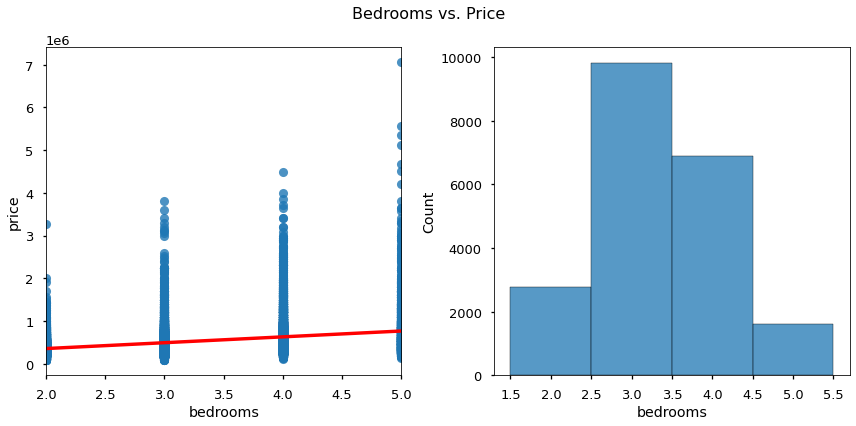

In [28]:
show_cleaned_vis(df,"bedrooms", discrete=True, kde = False)

***
**Observations**
>* There is a slight linear regression between the number of bedrooms and the sell price, indicated by the positive slope of the regression line.
>
>* As the number of bedrooms range from 2 - 5 as whole numbers, I will treat 'bedrooms' as a discrete/categorical feature.
>
>* The histogram slightly resembles a normal distribution, although the first bin is lower than I would expect for a normal distribution.

***
**TO-DO**
>* Use Bedrooms as a continuous variable.
***

### Bathrooms

There were 561 outliers.


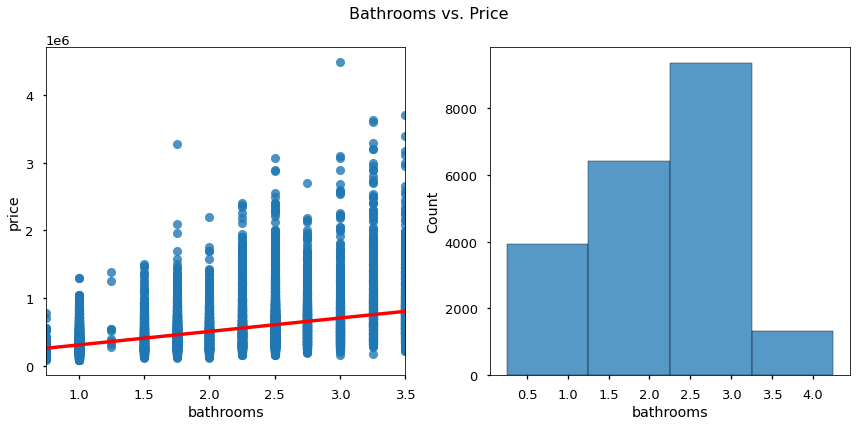

In [29]:
show_cleaned_vis(df,"bathrooms", discrete=True, kde=False)

***
**Observations**
>* Clear linear relationship between bathrooms and price.
>
>* The histogram/normal distribution isn't the strongest, but I feel it is good enough.
>
>* Simiar to bedrooms, the values for number of bathrooms are discrete and fall into specific values. This indicaes that the feature is categorical.
***
**TO-DO**
>* Use as continuous variable.
*** 

### sqft_living

There were 571 outliers.


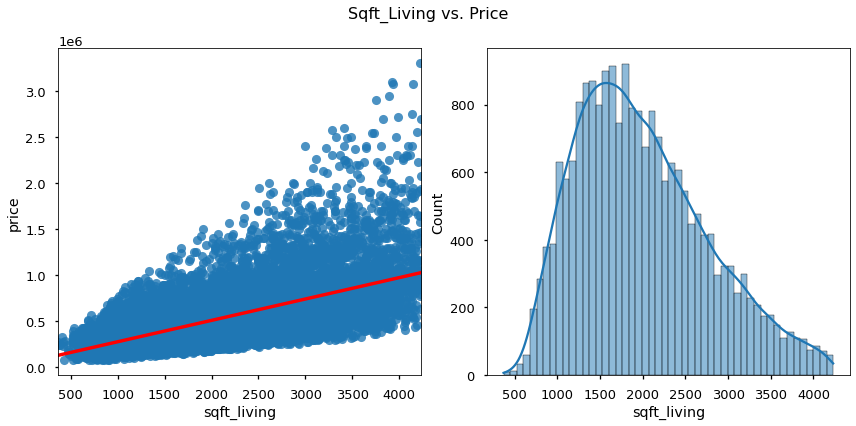

In [30]:
show_cleaned_vis(df,"sqft_living")

***
**Observations**

>* Clear linear relationship, although the distribution is slightly skewed to the right, indicating it's not a perfect normal distribution.
>
>* As the values are spread across the whole range, this feature is clearly a continuous variable.

***

**TO-DO**

>* Use as continuous variable


### sqft_lot

There were 2419 outliers.


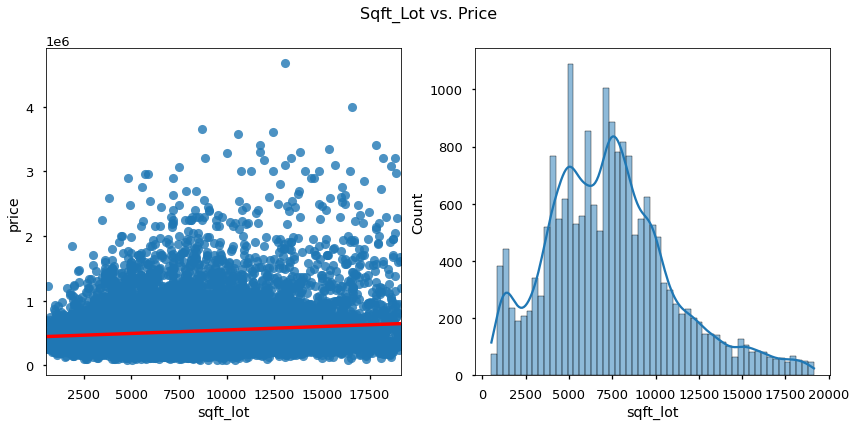

In [31]:
show_cleaned_vis(df,"sqft_lot")

***
**Observations**

>* Neither normally distributed nor having a linear relationship with price.
***

**TO-DO**

>* Treat as continuous variable as the values are spread out across the whole range.

* **

### floors

There were 0 outliers.


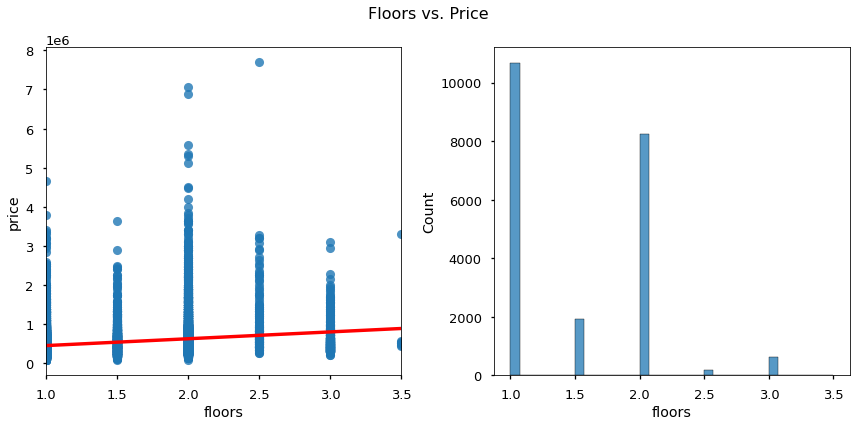

In [32]:
show_cleaned_vis(df,"floors", kde=False)

***
**Observations**

>* Linear relationship, but not normally distributed
>
>* Most homes had one or two bedrooms.

***
**TO-DO**

>* Treat as categorical variable due to discrete values
 
***

### waterfront

0.0    21451
1.0      146
Name: waterfront, dtype: int64


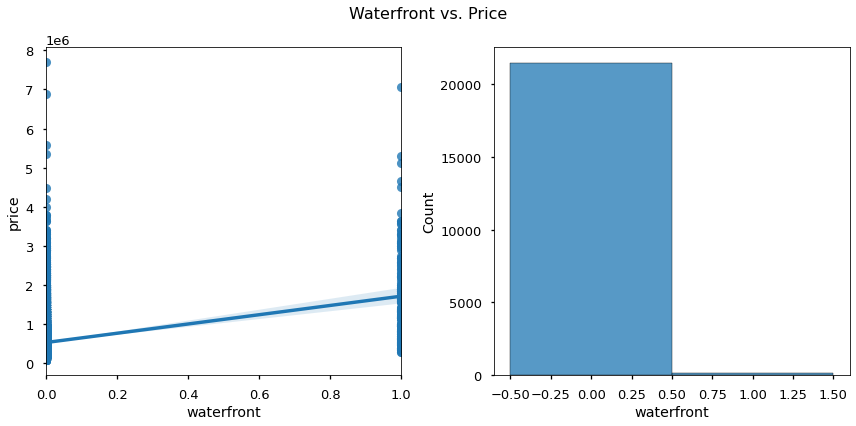

In [33]:
feature_vis(df,"waterfront", discrete=True, kde=False)

***
**Observations**

>* Graphs are misleading
>* Most properties are non-waterfront
>* Clear linear relationship, but not normally distributed

***
**TO-DO**

>* Treat as categorical - only two options (0 or 1).
 
***

### view

0.0    19485
1.0      330
2.0      957
3.0      508
4.0      317
Name: view, dtype: int64


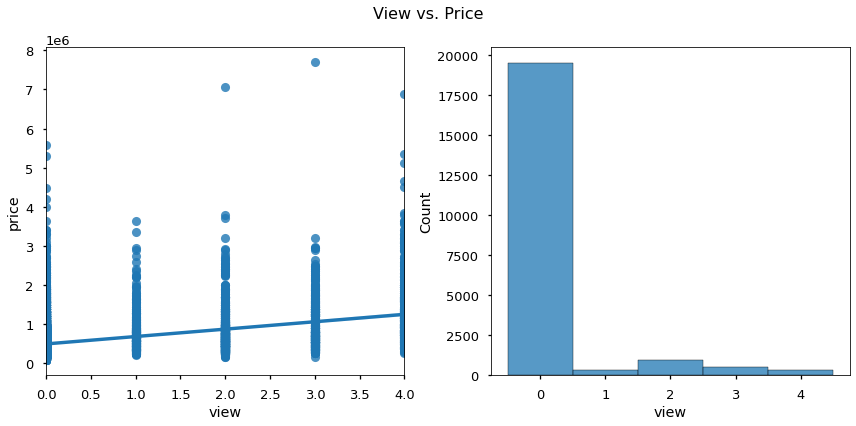

In [34]:
feature_vis(df,"view", discrete=True, kde=False)

***
**Observations**

>* Slight linear relationship - higher "view" rating, higher price
>* Most have '0' view
>* A few extreme outliers in pricing (for values 2, 3, and 4s)

***
**TO-DO**

>* Treat as categorical
 
***

### condition

There were 29 outliers.


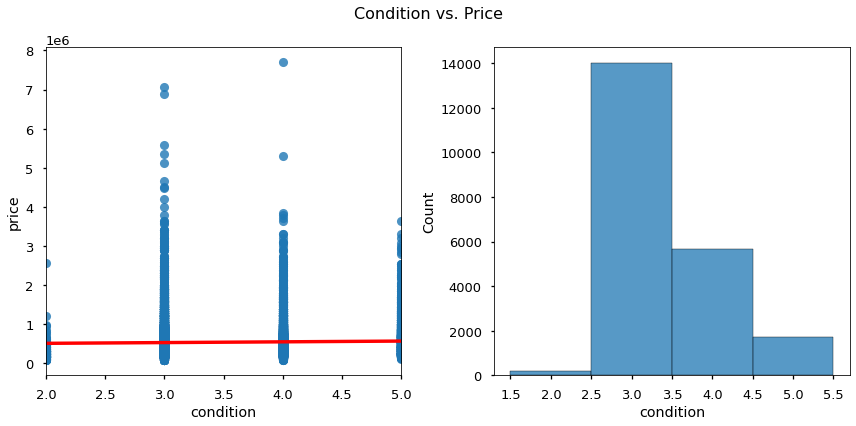

In [35]:
show_cleaned_vis(df,"condition", discrete=True, kde= False)

***
**Observations**

>* Largest number of homes sold were in condition 3, followed by 4
>* Very few sold in 1s, 2s
>* Price outliers in 4.0 area, some slight outliers in 2 and 3
>* No linear relationship, not normal distribution.

***
**TO-DO**

>* Treat as categorical
 
***

### grade

There were 1905 outliers.


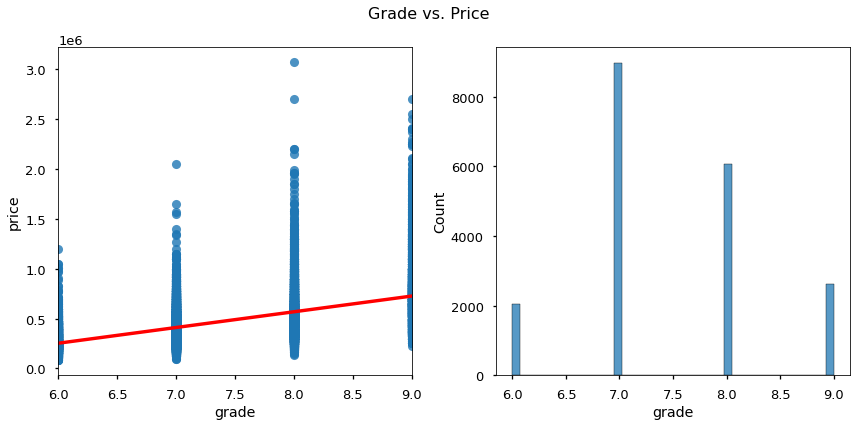

In [36]:
show_cleaned_vis(df,"grade", kde=False)

**Observations**

>* Clear linear trend - as grade increases, so does price
>
>* Grades range from 6-9 - no outliers
---
**TO-DO**

>* Treat as categorica variable


### sqft_above

There were 610 outliers.


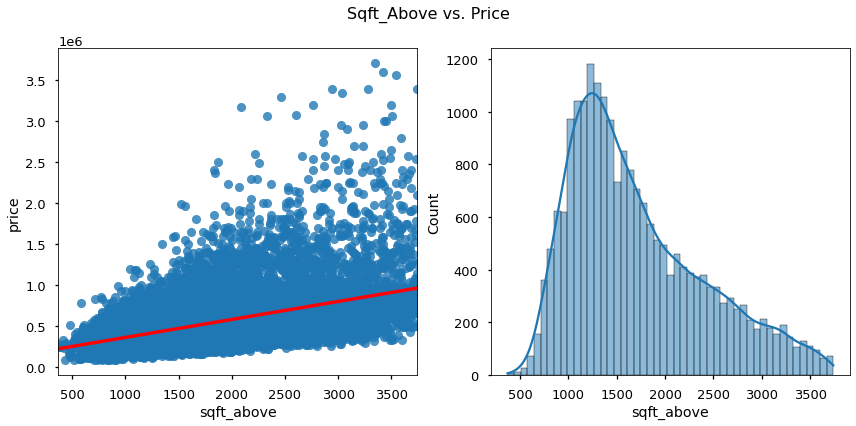

In [37]:
show_cleaned_vis(df,"sqft_above")

---

**Observations**

>* Outliers impacting accuracy of linear regression, but still seems relatively linear.
>
>* Distribution skewed right, but otherwise normal
---
**TO-DO**

>* Treat as continuous
---

### sqft_basement

There were 560 outliers.


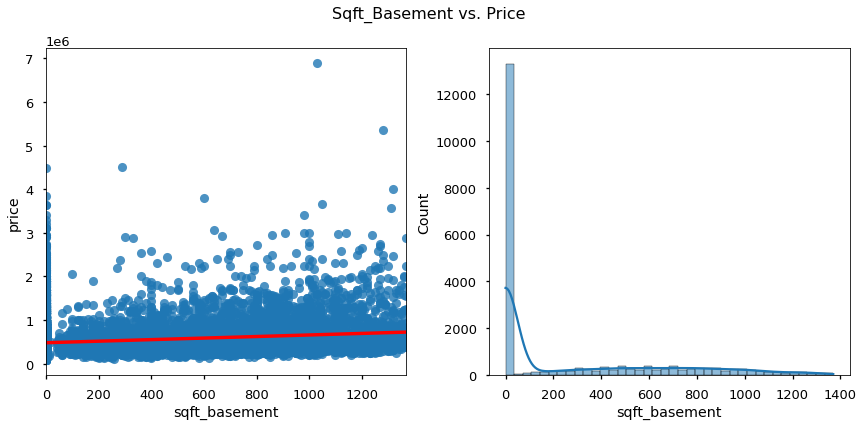

In [38]:
show_cleaned_vis(df,"sqft_basement")

---
**Observations**

>* Lots of 0 sqft basements -  shows no basement at all on property
>
>* scattered outliers; poor regression due to 0s
---
**TO-DO**

>* Treat as continuous if used for modeling
>
>* Can create new categorical, binary variable to indicate whether or not a house has a basement to measure the impact on price.
---

### yr_built

There were 0 outliers.


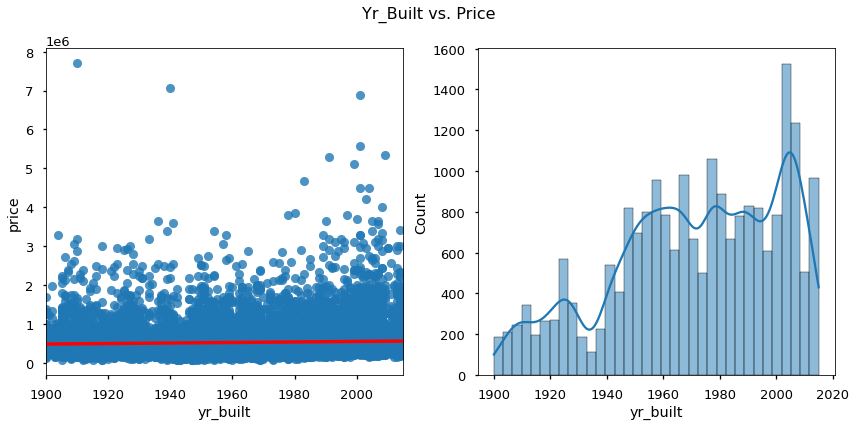

In [39]:
show_cleaned_vis(df,"yr_built")

---
**Observations**

>* Non-linear trend from this regression plot
>
>* Seems like may houses built between 1940 - 1970, then major boom in early 2000s.
>
>* Some significant outliers with price, but not affecting regression
---

**TO-DO**

>* Compare to year sold - how old was the house at sale?
>
>* Treat as categorical due to regression plot.
---

### yr_renovated

0.0       20853
1934.0        1
1940.0        2
1944.0        1
1945.0        3
          ...  
2011.0        9
2012.0        8
2013.0       31
2014.0       73
2015.0       14
Name: yr_renovated, Length: 70, dtype: int64


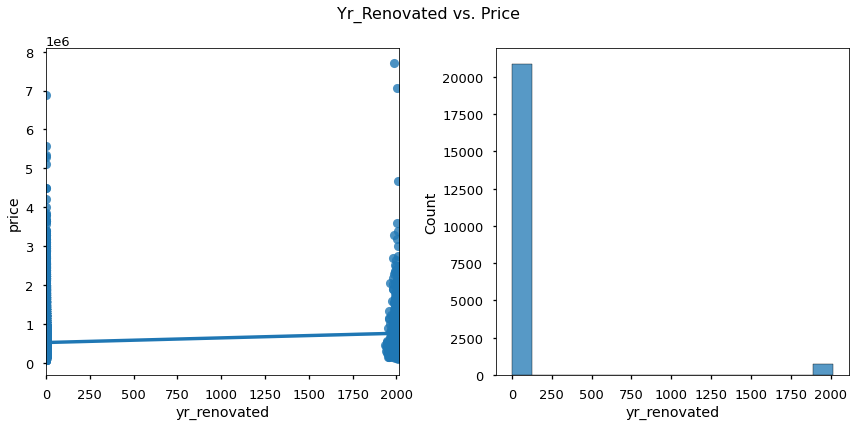

In [40]:
feature_vis(df,'yr_renovated', kde=False)


**Observations**

>* Number of houses not renovated significantly outweighs the number renovated
>
>* Graphs indicate that an engineered feature for whether or not the house was renovated would be worthwhile.
---
**TO-DO**

>* Create new categorical feature - renovated or not

### zipcode

There were 0 outliers.


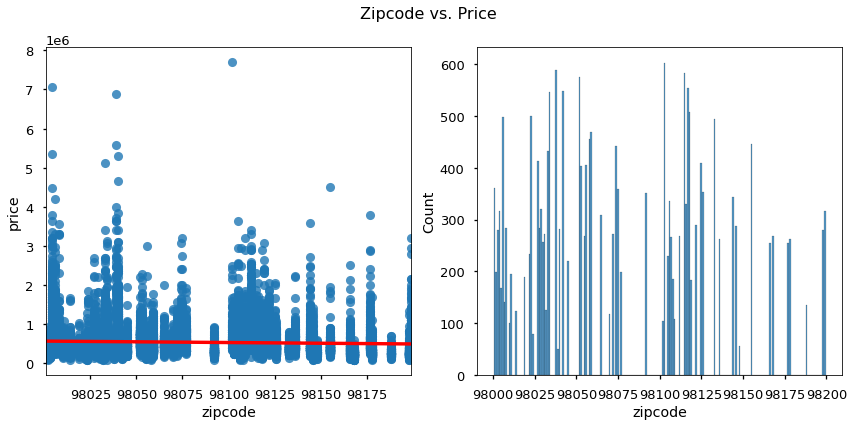

In [41]:
show_cleaned_vis(df,"zipcode", discrete=True, kde=False)

---
**Observations**

>* No linear relationship; not normally distributed
---
**TO-DO**

>* Treat as categorical variable
>
>* Perform OneHotEncoding to create new features for modeling.
---

### lat

There were 2 outliers.


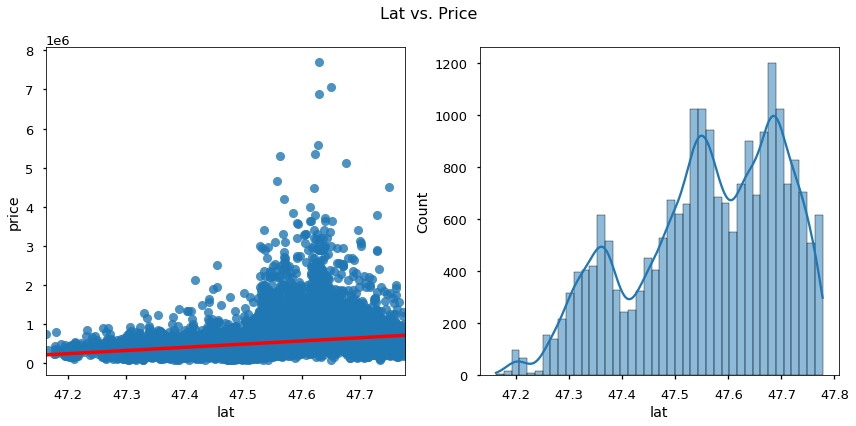

In [42]:
show_cleaned_vis(df,"lat")

**Observations**

>* Very weak linear relationship and not normally distributed.
>
>* Outliers just slightly past 47.6 degrees latitude

---
**TO-DO**

>* Treat as continuous if used for modeling.

### long

There were 255 outliers.


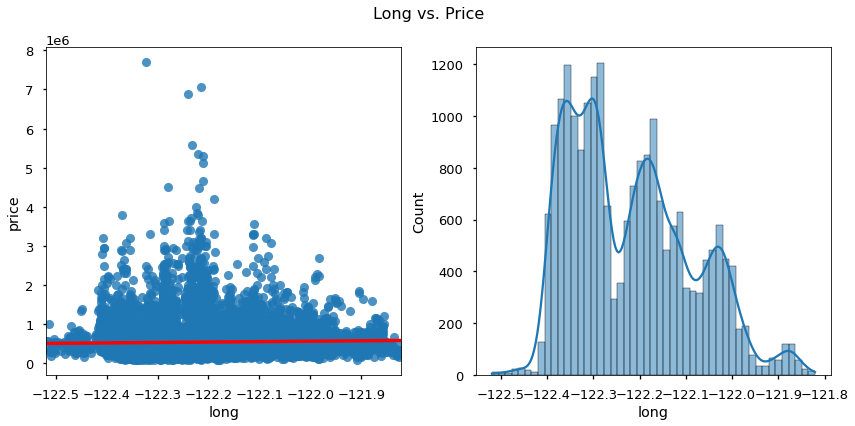

In [43]:
show_cleaned_vis(df,"long")

**Observations**

>* No linear relationship and not normally distributed.
>
>* Outliers around -122.32ish and -122.25-ish degrees

---
**TO-DO**

>* Treat as continuous if used for modeling.

### sqft_living15

There were 543 outliers.


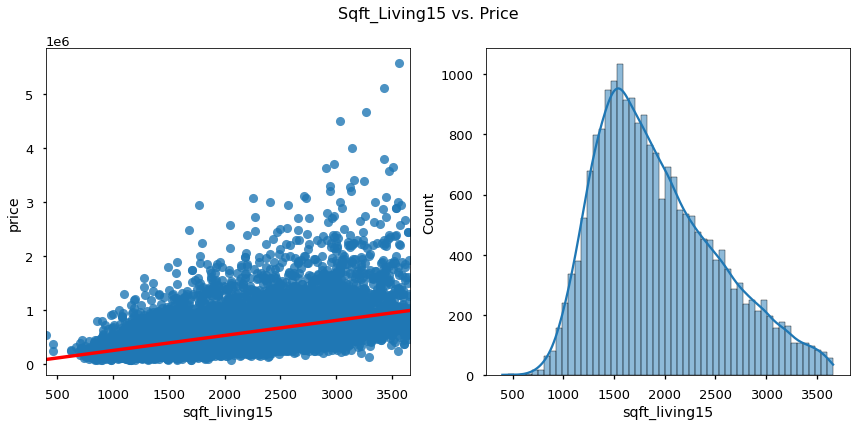

In [44]:
show_cleaned_vis(df,"sqft_living15")

---
**Observations**

>* Most properties sold with sqft between 1500/2000 
>
>* Price follows linear trend and is normally distributed, although skewed right.
>
>* Outliers between 2500-3500 ft$^2$ 
---
**TO-DO**

>* Treat as continuous variable
---

### sqft_lot15

There were 2188 outliers.


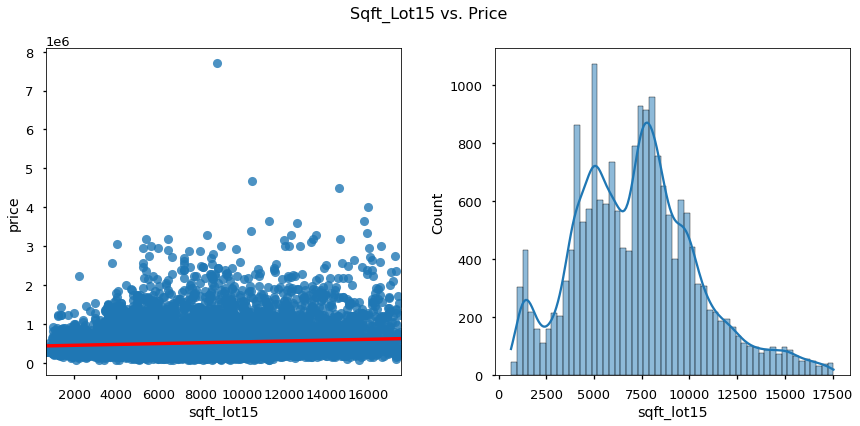

In [45]:
show_cleaned_vis(df,"sqft_lot15")

---
**Observations**

>* No clear linear trend
>* Significant outlier at approx. 9000 ft$^2$

---
**TO-DO**
>* Treat as continuous variable
---

# **Feature Engineering**

## Creating `'yrs_old_sold'`

I created this feature to differentiate between houses that were built recently versus older houses.

In order to determine this feature, I need to determine the year the house was sold first.

### Determine `'year_sold'`

In [46]:
## Pull the year from the "date" column
df['year_sold'] = pd. DatetimeIndex(df['date']).year

df['year_sold']

id
7129300520    2014
6414100192    2014
5631500400    2015
2487200875    2014
1954400510    2015
              ... 
263000018     2014
6600060120    2015
1523300141    2014
291310100     2015
1523300157    2014
Name: year_sold, Length: 21597, dtype: int64

In [47]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year_sold'],
      dtype='object')

In [48]:
## Confirm that it was created
'year_sold' in df.columns

True

In [49]:
## Review the values to ensure data integrity
df['year_sold'].value_counts()

2014    14622
2015     6975
Name: year_sold, dtype: int64

### Calculate `'y_old_sold'`

In [50]:
## Calculating the age of the house at the time of sale
df['y_old_sold'] = df['year_sold'] - df['yr_built']
df['y_old_sold'].describe()

## Minimum age is -1 due to a house being sold before it was finished being built

count    21597.000000
mean        43.323286
std         29.377285
min         -1.000000
25%         18.000000
50%         40.000000
75%         63.000000
max        115.000000
Name: y_old_sold, dtype: float64

In [51]:
## Confirming creation
'y_old_sold' in df.columns

True

In [52]:
## Confirming number of house entries
df['y_old_sold'].value_counts().sort_index()

-1       12
 0      430
 1      285
 2      174
 3      165
       ... 
 111     50
 112     33
 113     28
 114     69
 115     26
Name: y_old_sold, Length: 117, dtype: int64

In [53]:
## Reviewing the descriptive stats for the data
df['y_old_sold'].describe()

count    21597.000000
mean        43.323286
std         29.377285
min         -1.000000
25%         18.000000
50%         40.000000
75%         63.000000
max        115.000000
Name: y_old_sold, dtype: float64

## `'was_renovated'`

I created this feature to determine whether or not a house was renovated. If a house was renovated, what impact would that have on the price? 

In [54]:
## Using the year that the home was renovated to deterine whether or not the home was renovated
reno_y_n = np.where(df['yr_renovated']>0, 1, 0 )
df = df.assign(was_renovated = reno_y_n)
df.head(5)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,y_old_sold,was_renovated
id,,,,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,2014,59,0
6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,2014,63,1
5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,2015,82,0
2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,2014,49,0
1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2015,28,0


In [55]:
## Checking values
df['was_renovated'].value_counts()

0    20853
1      744
Name: was_renovated, dtype: int64

## `"yrs_since_reno"`

If a house was renovated, how long ago was the renovation? Would more newly-renovated houses increase price?

In [56]:
## Ensuring there are no null values in the new feature and replacing any with zeroes

df['yrs_since_reno'] = np.where((df['was_renovated']==1),
                                (df['year_sold'] - df['yr_renovated']), 0)

display(df['yrs_since_reno'].describe(),df['yrs_since_reno'].value_counts())

# Minimum age is -1 due to a house being sold before it was finished being built

count    21597.000000
mean         0.631986
std          4.424853
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         80.000000
Name: yrs_since_reno, dtype: float64

0.0     20921
1.0        37
8.0        34
10.0       29
11.0       27
        ...  
65.0        1
60.0        1
53.0        1
61.0        1
57.0        1
Name: yrs_since_reno, Length: 70, dtype: int64

## "`has_bsmnt`"

I noticed that there were fewer houses with a value for "sqft_basement" during my data exploration. I am curious if the presence or absence of a basement would have any impact.

In [57]:
## Determining whether or not a house has a basement based on the square footage
df['has_bsmnt'] = np.where(df['sqft_basement'] > 0, 1, 0)

# Reviewing the results
display(df['has_bsmnt'].describe(), df['has_bsmnt'].value_counts())

count    21597.00000
mean         0.38510
std          0.48663
min          0.00000
25%          0.00000
50%          0.00000
75%          1.00000
max          1.00000
Name: has_bsmnt, dtype: float64

0    13280
1     8317
Name: has_bsmnt, dtype: int64

# **Correlations**

## Determining Correlations with Price

In [58]:
## Determining top five features most strongly correlated with price
## C(onsidering absolute values for magnitude, not direction)

df_corr = np.abs(df.drop(['price', 'lat','long'], axis=1).corrwith(df['price']).sort_values(ascending=False))
display(df_corr[0:5])

sqft_living      0.701917
grade            0.667951
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
dtype: float64

## Determining Multicollinearity

In [59]:
## Get the correlation matrix for the data (without the target)
corr = np.abs(df.drop('price',axis=1).corr())
corr.round(2)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,y_old_sold,was_renovated,yrs_since_reno,has_bsmnt
bedrooms,1.00,0.51,0.58,0.03,0.18,0.00,0.08,0.03,0.36,0.48,0.30,0.16,0.02,0.15,0.01,0.13,0.39,0.03,0.01,0.16,0.02,0.01,0.16
bathrooms,0.51,1.00,0.76,0.09,0.50,0.06,0.19,0.13,0.67,0.69,0.28,0.51,0.05,0.20,0.02,0.22,0.57,0.09,0.03,0.51,0.05,0.00,0.16
sqft_living,0.58,0.76,1.00,0.17,0.35,0.10,0.28,0.06,0.76,0.88,0.43,0.32,0.05,0.20,0.05,0.24,0.76,0.18,0.03,0.32,0.05,0.02,0.20
sqft_lot,0.03,0.09,0.17,1.00,0.00,0.02,0.08,0.01,0.11,0.18,0.02,0.05,0.00,0.13,0.09,0.23,0.14,0.72,0.01,0.05,0.01,0.01,0.03
floors,0.18,0.50,0.35,0.00,1.00,0.02,0.03,0.26,0.46,0.52,0.24,0.49,0.00,0.06,0.05,0.13,0.28,0.01,0.02,0.49,0.00,0.00,0.25
waterfront,0.00,0.06,0.10,0.02,0.02,1.00,0.38,0.02,0.08,0.07,0.08,0.02,0.07,0.03,0.01,0.04,0.08,0.03,0.01,0.02,0.07,0.08,0.04
view,0.08,0.19,0.28,0.08,0.03,0.38,1.00,0.05,0.25,0.17,0.27,0.05,0.09,0.09,0.01,0.08,0.28,0.07,0.00,0.05,0.09,0.08,0.18
condition,0.03,0.13,0.06,0.01,0.26,0.02,0.05,1.00,0.15,0.16,0.17,0.36,0.06,0.00,0.02,0.11,0.09,0.00,0.05,0.36,0.06,0.01,0.13
grade,0.36,0.67,0.76,0.11,0.46,0.08,0.25,0.15,1.00,0.76,0.17,0.45,0.02,0.19,0.11,0.20,0.71,0.12,0.03,0.45,0.02,0.02,0.05
sqft_above,0.48,0.69,0.88,0.18,0.52,0.07,0.17,0.16,0.76,1.00,0.05,0.42,0.02,0.26,0.00,0.34,0.73,0.20,0.02,0.42,0.02,0.01,0.21


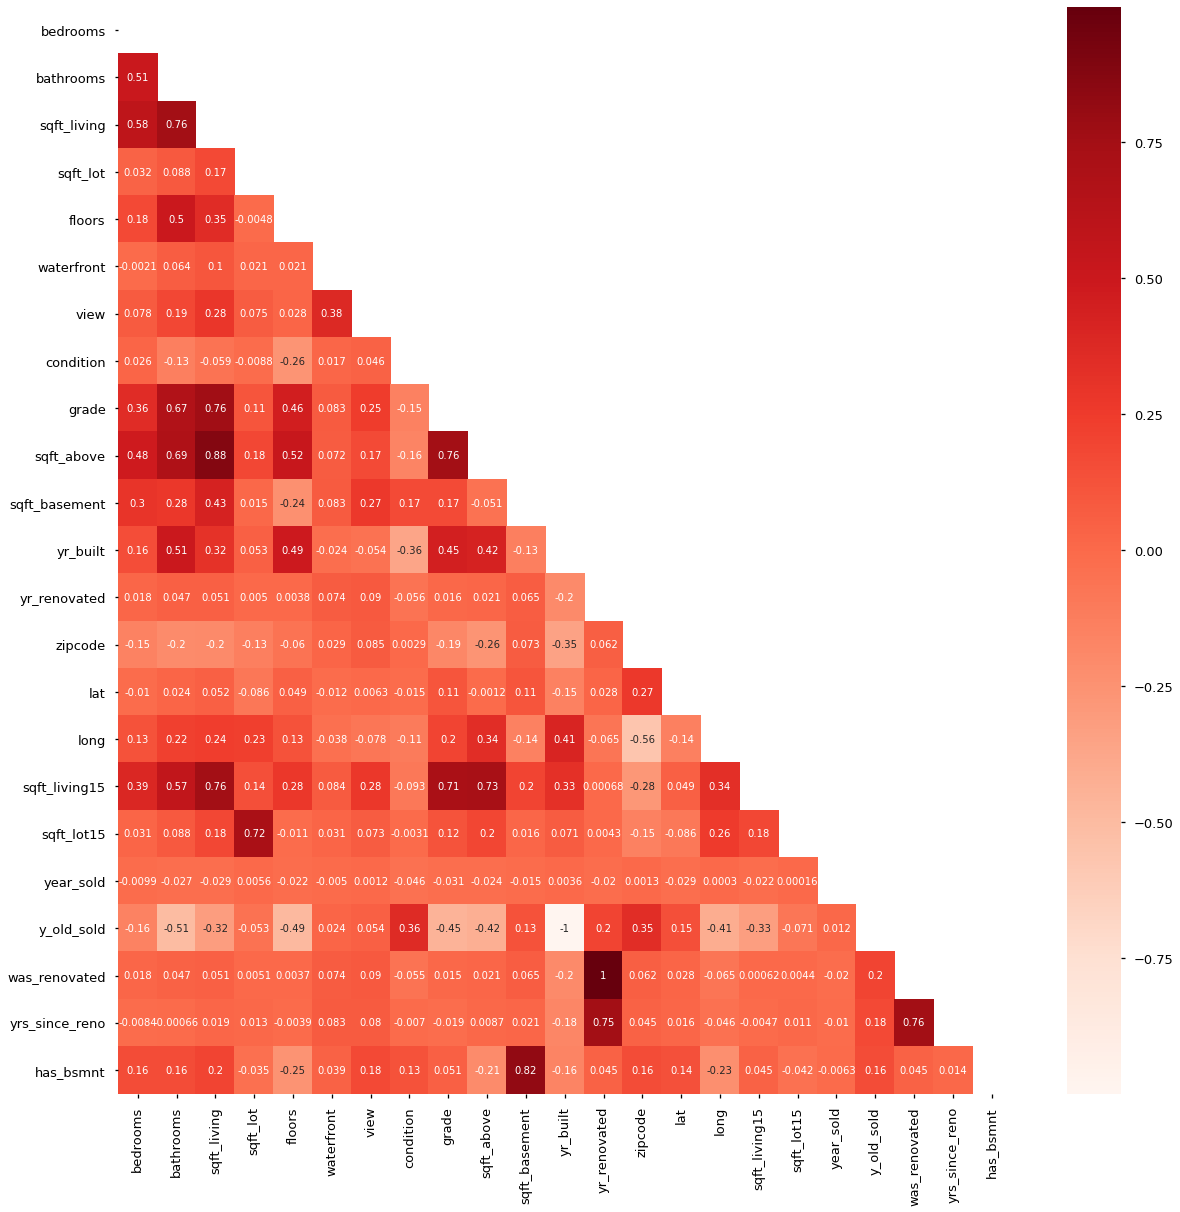

In [60]:
corr_val(df.drop('price',axis=1), figsize=(20,20));

In [61]:
## Correlation results ignoring duplicate values 
## Except for "was_renovated", which shows a perfect relationship to itself

df_corr_results = df.corr().unstack().sort_values(ascending=False).drop_duplicates()

In [62]:
# Show strongest postive and negative correlations
display(df_corr_results[1:11], df_corr_results[-11:-1])

was_renovated   yr_renovated     0.999968
sqft_living     sqft_above       0.876448
has_bsmnt       sqft_basement    0.820893
sqft_living     grade            0.762779
                sqft_living15    0.756402
yrs_since_reno  was_renovated    0.756165
sqft_above      grade            0.756073
bathrooms       sqft_living      0.755758
yrs_since_reno  yr_renovated     0.750942
sqft_living15   sqft_above       0.731767
dtype: float64

y_old_sold  sqft_living     -0.318592
            sqft_living15   -0.326697
yr_built    zipcode         -0.347210
            condition       -0.361592
long        y_old_sold      -0.409959
sqft_above  y_old_sold      -0.424386
y_old_sold  grade           -0.448322
            floors          -0.489514
bathrooms   y_old_sold      -0.507561
zipcode     long            -0.564259
dtype: float64

In [63]:
# drop_col = []

# for key, val in df_corr_results.items():
#     if np.abs(val) >= .75:
# #         print(key, val)
#         drop_col.append(key)

# drop_col

In [64]:
# Dropping columns to address multicollinearity (over .75)

try:
    df.drop(['yr_renovated','sqft_basement','sqft_above', 'y_old_sold'], axis=1, inplace=True)
except:
    pass

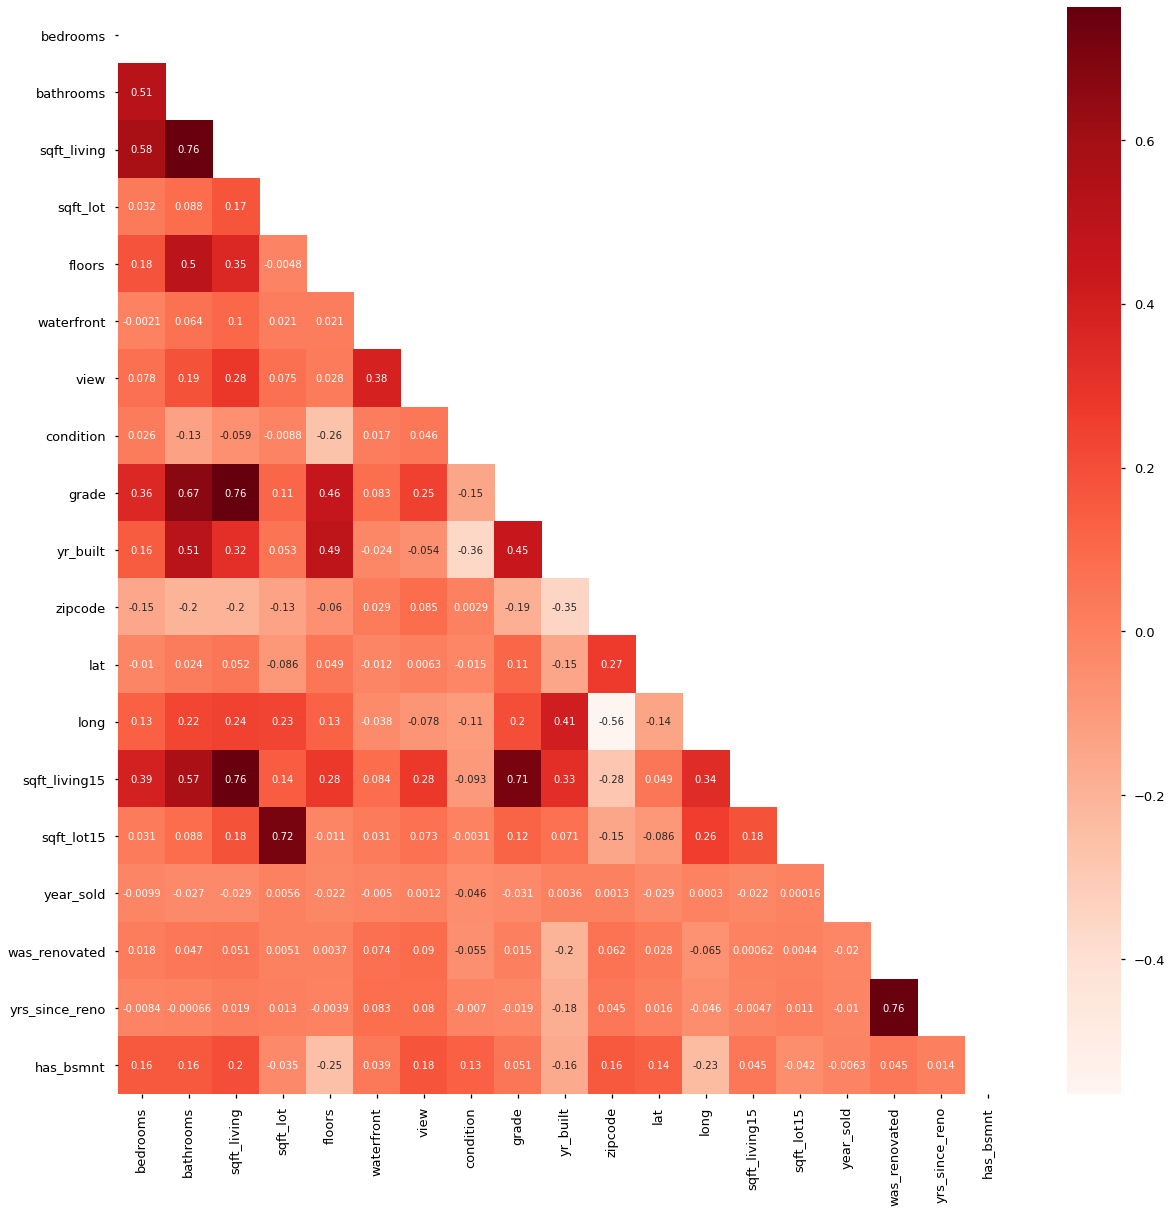

In [65]:
# Rerunning model

corr_val(df.drop('price',axis=1), figsize=(20,20));

In [66]:
# Correlation results ignoring (most) duplicate values
df_corr_results = df.corr().unstack().sort_values(ascending=False).drop_duplicates()

# Show strongest postive and negative correlations
display(df_corr_results[1:11], df_corr_results[-11:-1])

sqft_living    grade             0.762779
               sqft_living15     0.756402
was_renovated  yrs_since_reno    0.756165
sqft_living    bathrooms         0.755758
sqft_lot       sqft_lot15        0.718204
sqft_living15  grade             0.713867
price          sqft_living       0.701917
               grade             0.667951
grade          bathrooms         0.665838
sqft_living15  price             0.585241
dtype: float64

grade          zipcode         -0.185771
sqft_living    zipcode         -0.199802
was_renovated  yr_built        -0.202837
bathrooms      zipcode         -0.204786
has_bsmnt      long            -0.233366
               floors          -0.252465
condition      floors          -0.264075
zipcode        sqft_living15   -0.279299
               yr_built        -0.347210
condition      yr_built        -0.361592
dtype: float64

### Interpretation of Correlations

***
**Top 10 Positive Relationships**
>* Nothing too surprising as most of the matches are intuitively related.
>  * E.g. "yr_renovated" and "was_renovated" have a nearly-perfect positive correlation as "was_renovated" is determined by "yr_renovated" in our feature engineering.
>
>
>* Two interesting relationships would be:
>  * The living space (ft^2) and grade
>    * Indicates that a larger house has a higher grade
> * The living space (ft^2) of the 15 nearest houses sold
>   * Indicates a larger area above ground (ft^2)
>    * Perhaps larger houses are more likely to be nearby each other?
***
**Top 10 Negative Relationships**
>* Older houses may have fewer bathrooms
>* Older houses may have fewer floors
>* Older houses have a lower grade
***

# **Statistical Testing**

## One-Way ANOVA

I would assume that the condition of a house would have an impact on the price of a house (who would pay more for a run-down house that would need a lot of repair work?).

I wanted to confirm that the different condition levels would be significant for modeling.

### *Testing `'condition'`*

* H0: The feature "condition" does not have an effect on price.

* Ha: The feature "condition" does  have an effect on price.


In [67]:
## Defining variables for the prices of each value of conditions

condition_1 = df.loc[df['condition'] == 1, 'price']
condition_2 = df.loc[df['condition'] == 2, 'price']
condition_3 = df.loc[df['condition'] == 3, 'price']
condition_4 = df.loc[df['condition'] == 4, 'price']
condition_5 = df.loc[df['condition'] == 5, 'price']

In [68]:
## Running ANOVA test to determine significance

## Define alpha
alpha = .05

## Run test
result = stats.f_oneway(condition_1, condition_2, condition_3, condition_4, condition_5)
f_stat, p_value = result

# Evaluate signficance
if p_value < .05:
    print(f'The condition of a home is statistically significant with a p-value of {p_value}.')
    
else:
     print(f'The condition of a home is not statistically significant with a p-value of {p_value}.')

The condition of a home is statistically significant with a p-value of 9.121587122785116e-31.


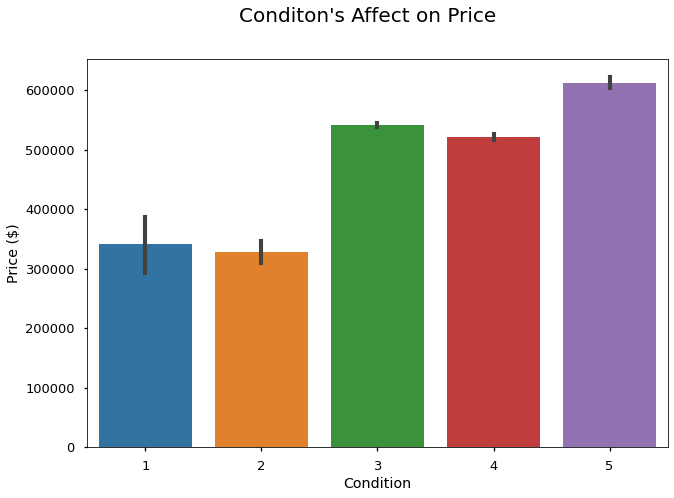

In [69]:
# Show visual of conclusion

sns.barplot(data=df, x= 'condition', y = 'price', ci=68)
plt.suptitle("Conditon's Affect on Price", size = (20))
plt.xlabel('Condition')
plt.ylabel('Price ($)');

#### Interpretation

> The t-test shows that the condition of a house is statistically significant due to the p-value below our alpha of .05.
>
> This means that the quality of a house will have a statistically significant impact on the sell price.

## Two-Sample T-Tests

Again, common sense tells us that waterfront homes would sell for higher prices, but I wanted to confirm that assumption.

### *Testing  `'waterfront'`*

---
**Hypotheses**

>* **H0:** The feature "waterfront" does not have an effect on price.
>
>* **HA:** The feature "waterfront" does  have an effect on price.
>
>* **Alpha** = .05
---

In [70]:
# Set variables to represent whether or not a property is listed as 'waterfront.'

wf_yes = df.loc[df['waterfront'] == 1, 'price']
wf_no = df.loc[df['waterfront'] == 0, 'price']

In [71]:
ttest_review(wf_yes, wf_no)

The feature "waterfront" is statistically significant with a p-value of 0.0.


0.0

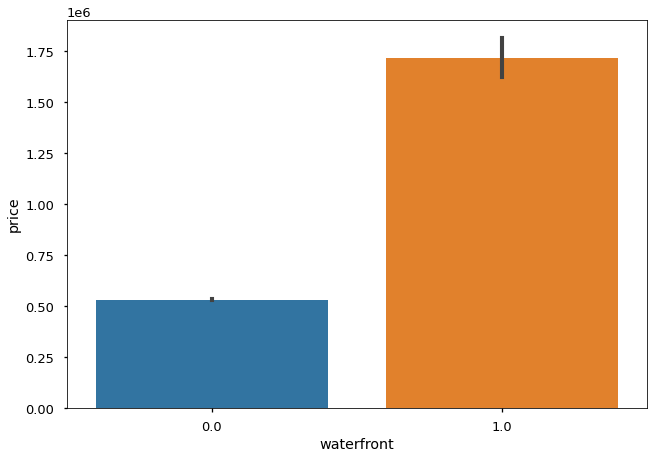

In [72]:
# Show visual of conclusion

sns.barplot(data=df, x= 'waterfront', y = 'price', ci=68);

#### Interpretation

> The t-test shows that waterfront is statistically significant due to the p-value below our alpha of .05.
>
> This means that having a house on the waterfront will have a significant impact on the sell price.

### *Testing `"was_renovated"`*

**Hypotheses**

---
>* **H0:** There is not a statistically significant difference in price in homes with a basement than those without.
>
>* **HA:** There is a statistically significant difference in price in homes with a basement than those without.
>
>* **Alpha** = 0.05
---

In [73]:
reno_y = df.loc[df['was_renovated'] == 1, 'price']
reno_n = df.loc[df['was_renovated'] == 0, 'price']


In [74]:
ttest_review(reno_y, reno_n)

The feature "waterfront" is statistically significant with a p-value of 2.6444319499967275e-67.


2.6444319499967275e-67

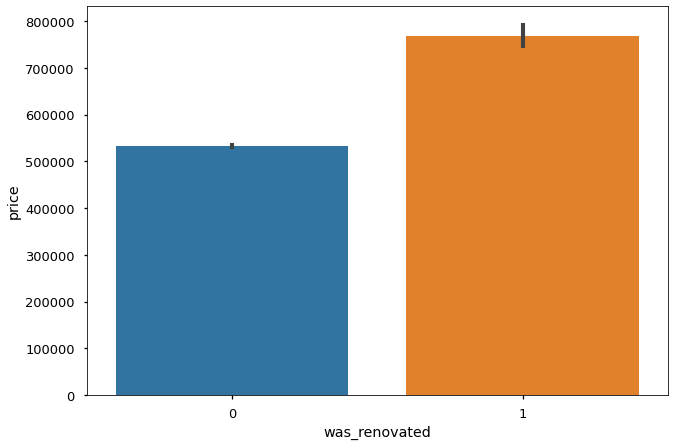

In [75]:
# Show visual of conclusion

sns.barplot(data=df, x= 'was_renovated', y = 'price', ci=68);

#### Interpretation

> The t-test shows that having a basement is statistically significant due to the p-value below our alpha of .05.
>
> This means that having a house with a basement will have a significant impact on the sell price.

# **Inferential Modeling**

## Baseline Model with Raw Data

Creating a baseline model using the raw dataset.

In [76]:
## Reviewing feature names and their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            21597 non-null  datetime64[ns]
 1   price           21597 non-null  float64       
 2   bedrooms        21597 non-null  int64         
 3   bathrooms       21597 non-null  float64       
 4   sqft_living     21597 non-null  int64         
 5   sqft_lot        21597 non-null  int64         
 6   floors          21597 non-null  float64       
 7   waterfront      21597 non-null  float64       
 8   view            21597 non-null  float64       
 9   condition       21597 non-null  int64         
 10  grade           21597 non-null  int64         
 11  yr_built        21597 non-null  int64         
 12  zipcode         21597 non-null  int64         
 13  lat             21597 non-null  float64       
 14  long            21597 non-null  float64 

price~+yrs_since_reno+bedrooms+bathrooms+condition+grade+floors+C(was_renovated)+C(has_bsmnt)+C(waterfront)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     2807.
Date:                Mon, 12 Jul 2021   Prob (F-statistic):               0.00
Time:                        19:24:00   Log-Likelihood:            -2.9902e+05
No. Observations:               21597   AIC:                         5.981e+05
Df Residuals:                   21587   BIC:                         5.981e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1.263e+06   1.65e+04    -76.506      0.000    -1.3e+06   -1.23e+06
C(was_renovated)[T.1]  2.237e+05   1.43e+04     15.622      0.000    1.96e+05    2.52e+05
C(has_bsmnt)[T.1]      6.872e+04   3855.000     17.825      0.000    6.12e+04    7.63e+04
C(waterfront)[T.1.0]   8.837e+05   2.09e+04     42.273      0.000    8.43e+05    9.25e+05
yrs_since_reno        -2237.6524    588.772     -3.801      0.000   -3391.688   -1083.617
bedrooms               9314.3073   2164.779      4.303      0.000    5071.180    1.36e+04
bathrooms              5.699e+04   3512.708     16.224      0.000    5.01e+04    6.39e+04
condition              6.808e+04   2733.671     24.905      0.000    6.27e+04    7.34e+04
grade                  1.837e+05   1984.519     92.591      0.000     1.8e+05    1.88e+05
floors                -1.794e+04   4094.141     -4.382      0.000    -2.6e+04   -9915.032
==============================================================================
Omnibus:                    18184.342   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1644322.251
Skew:                           3.546   Prob(JB):                         0.00
Kurtosis:                      45.154   Cond. No.                         118.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

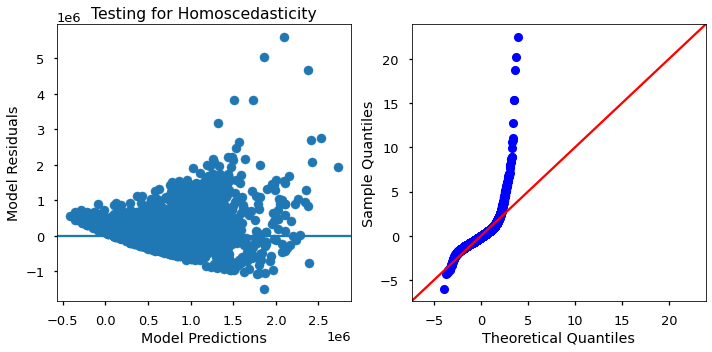

In [77]:
## Establishing the features for inferential modeling

categorical_features = ['was_renovated','has_bsmnt', 'waterfront']

continuous_features = ['yrs_since_reno', 'bedrooms', 'bathrooms',
                       'condition','grade', 'floors']

model_baseline = create_model(df,continuous_features,categorical_features);

---
**Interpretation:**

>* R^2: ~.6, less than target of .75
>
>* Residual plots show heteroscedasticity
>
>* Q-Q Plot shows non-normal residuals
>
>* Changes: remove outliers and retest
---

## Model without Outliers in 'Price'

What would the model look like if we ignored the outliers?

### Removing Outliers from 'Price' Data

In [78]:
## Remove outliers from price 
idx_outs = find_outliers_z(df['price'])
df_clean = df[~idx_outs].copy()
df_clean

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,was_renovated,yrs_since_reno,has_bsmnt
id,,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1955,98178,47.5112,-122.257,1340,5650,2014,0,0.0,0
6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,1951,98125,47.7210,-122.319,1690,7639,2014,1,23.0,1
5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,1933,98028,47.7379,-122.233,2720,8062,2015,0,0.0,0
2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1965,98136,47.5208,-122.393,1360,5000,2014,0,0.0,1
1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1987,98074,47.6168,-122.045,1800,7503,2015,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,2009,98103,47.6993,-122.346,1530,1509,2014,0,0.0,0
6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2014,98146,47.5107,-122.362,1830,7200,2015,0,0.0,0
1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,2009,98144,47.5944,-122.299,1020,2007,2014,0,0.0,0


In [79]:
## Remove outliers from bedrooms
idx_outs = find_outliers_z(df_clean['bedrooms'])
df_clean = df_clean[~idx_outs].copy()

df_clean

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,was_renovated,yrs_since_reno,has_bsmnt
id,,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1955,98178,47.5112,-122.257,1340,5650,2014,0,0.0,0
6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,1951,98125,47.7210,-122.319,1690,7639,2014,1,23.0,1
5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,1933,98028,47.7379,-122.233,2720,8062,2015,0,0.0,0
2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1965,98136,47.5208,-122.393,1360,5000,2014,0,0.0,1
1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1987,98074,47.6168,-122.045,1800,7503,2015,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,2009,98103,47.6993,-122.346,1530,1509,2014,0,0.0,0
6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2014,98146,47.5107,-122.362,1830,7200,2015,0,0.0,0
1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,2009,98144,47.5944,-122.299,1020,2007,2014,0,0.0,0


In [80]:
df_clean.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,was_renovated,yrs_since_reno,has_bsmnt
count,2.113900e+04,21139.000000,21139.000000,21139.000000,2.113900e+04,21139.000000,21139.000000,21139.000000,21139.000000,21139.000000,21139.000000,21139.000000,21139.000000,21139.000000,21139.00000,21139.000000,21139.000000,21139.000000,21139.000000,21139.000000
mean,5.065845e+05,3.344293,2.084027,2029.038885,1.483707e+04,1.486447,0.003784,0.204693,3.408108,7.604806,1970.960358,98078.258763,47.558848,-122.213620,1960.22177,12642.165760,2014.322721,0.032546,0.603529,0.379488
std,2.593151e+05,0.868827,0.730935,833.210367,4.044749e+04,0.538400,0.061403,0.706581,0.648960,1.108900,29.274773,53.416557,0.139524,0.141498,655.23770,27223.583749,0.467528,0.177451,4.371883,0.485271
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,1900.000000,98001.000000,47.155900,-122.519000,399.00000,651.000000,2014.000000,0.000000,-1.000000,0.000000
25%,3.200000e+05,3.000000,1.500000,1410.000000,5.006500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1952.000000,98033.000000,47.466700,-122.329000,1480.00000,5083.000000,2014.000000,0.000000,0.000000,0.000000
50%,4.460000e+05,3.000000,2.250000,1890.000000,7.560000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1975.000000,98065.000000,47.569700,-122.231000,1820.00000,7579.000000,2014.000000,0.000000,0.000000,0.000000
75%,6.260500e+05,4.000000,2.500000,2500.000000,1.048900e+04,2.000000,0.000000,0.000000,4.000000,8.000000,1996.000000,98118.000000,47.678800,-122.124000,2330.00000,10000.000000,2015.000000,0.000000,0.000000,1.000000
max,1.640000e+06,6.000000,6.500000,7350.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,12.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.00000,871200.000000,2015.000000,1.000000,80.000000,1.000000


price~+yrs_since_reno+bedrooms+bathrooms+condition+grade+floors+C(was_renovated)+C(has_bsmnt)+C(waterfront)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     2504.
Date:                Mon, 12 Jul 2021   Prob (F-statistic):               0.00
Time:                        19:24:01   Log-Likelihood:            -2.8584e+05
No. Observations:               21139   AIC:                         5.717e+05
Df Residuals:                   21129   BIC:                         5.718e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -9.352e+05   1.24e+04    -75.251      0.000    -9.6e+05   -9.11e+05
C(was_renovated)[T.1]  1.725e+05   1.07e+04     16.144      0.000    1.52e+05    1.93e+05
C(has_bsmnt)[T.1]      6.909e+04   2827.043     24.437      0.000    6.35e+04    7.46e+04
C(waterfront)[T.1.0]   3.519e+05   2.03e+04     17.325      0.000    3.12e+05    3.92e+05
yrs_since_reno        -1867.0850    432.931     -4.313      0.000   -2715.662   -1018.508
bedrooms               1.323e+04   1689.422      7.829      0.000    9915.349    1.65e+04
bathrooms              1.743e+04   2651.744      6.574      0.000    1.22e+04    2.26e+04
condition              5.581e+04   2006.846     27.811      0.000    5.19e+04    5.97e+04
grade                   1.47e+05   1498.890     98.093      0.000    1.44e+05     1.5e+05
floors                 1.403e+04   3025.653      4.636      0.000    8094.934       2e+04
==============================================================================
Omnibus:                     3481.565   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7593.353
Skew:                           0.970   Prob(JB):                         0.00
Kurtosis:                       5.203   Cond. No.                         155.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

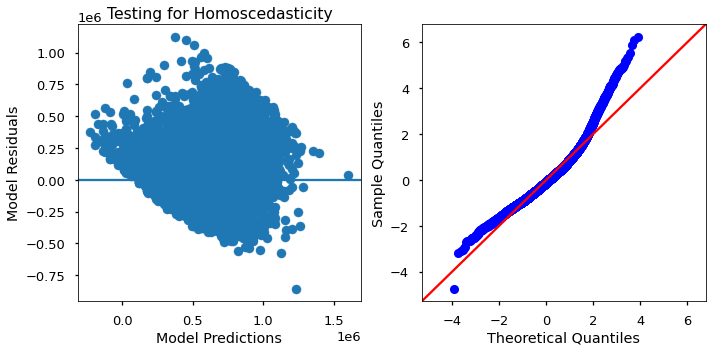

In [81]:
## Redefining updated features and re-running model

categorical_features = ['was_renovated','has_bsmnt', 'waterfront']

continuous_features = ['yrs_since_reno', 'bedrooms', 'bathrooms',
                       'condition','grade', 'floors']

model_clean = create_model(df_clean,cont=continuous_features,cat=categorical_features);

Interpretation:

* R^2: ~.59, less than target of .75 (performed slightly worse)

* Residual plots show somewhat increased homoscedasticity

* Q-Q Plot shows more normal residuals (vs. earlier plot)

* Changes: add zipcode 

## Model (Clean) - w/ Zip Codes

price~+yrs_since_reno+bedrooms+bathrooms+condition+grade+floors+C(was_renovated)+C(has_bsmnt)+C(waterfront)+C(zipcode)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     844.7
Date:                Mon, 12 Jul 2021   Prob (F-statistic):               0.00
Time:                        19:24:02   Log-Likelihood:            -2.7852e+05
No. Observations:               21139   AIC:                         5.572e+05
Df Residuals:                   21060   BIC:                         5.578e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -8.094e+05   1.14e+04    -70.693      0.000   -8.32e+05   -7.87e+05
C(was_renovated)[T.1]  9.715e+04   7634.078     12.726      0.000    8.22e+04    1.12e+05
C(has_bsmnt)[T.1]       396.2311   2207.937      0.179      0.858   -3931.495    4723.957
C(waterfront)[T.1.0]    4.34e+05   1.48e+04     29.293      0.000    4.05e+05    4.63e+05
C(zipcode)[T.98002]     1.38e+04   1.13e+04      1.219      0.223   -8384.450     3.6e+04
C(zipcode)[T.98003]   -2.052e+04   1.02e+04     -2.014      0.044   -4.05e+04    -544.930
C(zipcode)[T.98004]    6.186e+05   1.09e+04     56.987      0.000    5.97e+05     6.4e+05
C(zipcode)[T.98005]    3.234e+05   1.21e+04     26.618      0.000       3e+05    3.47e+05
C(zipcode)[T.98006]     2.96e+05   9085.753     32.574      0.000    2.78e+05    3.14e+05
C(zipcode)[T.98007]    2.292e+05   1.28e+04     17.868      0.000    2.04e+05    2.54e+05
C(zipcode)[T.98008]    2.399e+05   1.03e+04     23.358      0.000     2.2e+05     2.6e+05
C(zipcode)[T.98010]     1.22e+05   1.45e+04      8.437      0.000    9.37e+04     1.5e+05
C(zipcode)[T.98011]    1.429e+05   1.14e+04     12.559      0.000    1.21e+05    1.65e+05
C(zipcode)[T.98014]    1.747e+05   1.34e+04     13.079      0.000    1.49e+05    2.01e+05
C(zipcode)[T.98019]    1.225e+05   1.15e+04     10.672      0.000       1e+05    1.45e+05
C(zipcode)[T.98022]    3.981e+04   1.08e+04      3.696      0.000    1.87e+04    6.09e+04
C(zipcode)[T.98023]   -3.687e+04   8847.432     -4.168      0.000   -5.42e+04   -1.95e+04
C(zipcode)[T.98024]    2.316e+05   1.61e+04     14.425      0.000       2e+05    2.63e+05
C(zipcode)[T.98027]    1.962e+05   9310.979     21.073      0.000    1.78e+05    2.14e+05
C(zipcode)[T.98028]    1.358e+05   1.02e+04     13.370      0.000    1.16e+05    1.56e+05
C(zipcode)[T.98029]    1.914e+05   9901.295     19.328      0.000    1.72e+05    2.11e+05
C(zipcode)[T.98030]   -4587.8249   1.04e+04     -0.439      0.661   -2.51e+04    1.59e+04
C(zipcode)[T.98031]   -5432.9422   1.03e+04     -0.530      0.596   -2.55e+04    1.47e+04
C(zipcode)[T.98032]   -1.376e+04   1.33e+04     -1.035      0.301   -3.98e+04    1.23e+04
C(zipcode)[T.98033]    3.543e+05   9252.213     38.288      0.000    3.36e+05    3.72e+05
C(zipcode)[T.98034]    1.794e+05   8717.151     20.579      0.000    1.62e+05    1.96e+05
C(zipcode)[T.98038]    4.516e+04   8571.840      5.269      0.000    2.84e+04     6.2e+04
C(zipcode)[T.98039]    8.277e+05   3.09e+04     26.776      0.000    7.67e+05    8.88e+05
C(zipcode)[T.98040]     4.99e+05   1.08e+04     46.221      0.000    4.78e+05     5.2e+05
C(zipcode)[T.98042]    4289.6962   8678.763      0.494      0.621   -1.27e+04    2.13e+04
C(zipcode)[T.98045]    1.222e+05    1.1e+04     11.145      0.000    1.01e+05    1.44e+05
C(zipcode)[T.98052]    

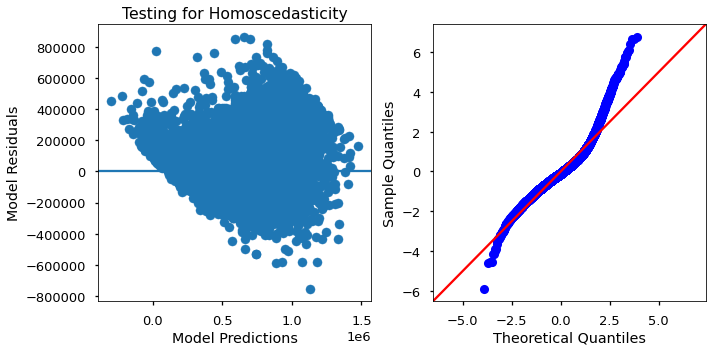

In [82]:
## Adding zip codes as a categorical variable

categorical_features = ['was_renovated','has_bsmnt', 'waterfront', 'zipcode']

continuous_features = ['yrs_since_reno', 'bedrooms', 'bathrooms',
                       'condition','grade', 'floors']

model_w_zip = create_model(df_clean,continuous_features, categorical_features)

Interpretation:

>* Model is significant with an R-squared value over the threshold of .75 (result: .77)
>
>* Residual plots show somewhat homoscedasticity
>
>* Q-Q Plot shows more normal residuals (vs. earlier plot)
>
>* Changes: remove features with p-values higher than .05 (statistically insignificant values)

price~+yrs_since_reno+bedrooms+bathrooms+condition+grade+C(was_renovated)+C(waterfront)+C(zipcode)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     856.1
Date:                Mon, 12 Jul 2021   Prob (F-statistic):               0.00
Time:                        19:24:48   Log-Likelihood:            -2.7862e+05
No. Observations:               21139   AIC:                         5.574e+05
Df Residuals:                   21062   BIC:                         5.580e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -8.299e+05   1.14e+04    -72.723      0.000   -8.52e+05   -8.08e+05
C(was_renovated)[T.1]  1.031e+05   7659.100     13.456      0.000     8.8e+04    1.18e+05
C(waterfront)[T.1.0]   4.329e+05   1.49e+04     29.095      0.000    4.04e+05    4.62e+05
C(zipcode)[T.98002]    1.153e+04   1.14e+04      1.015      0.310   -1.07e+04    3.38e+04
C(zipcode)[T.98003]    -1.59e+04   1.02e+04     -1.553      0.120    -3.6e+04    4161.624
C(zipcode)[T.98004]    6.238e+05   1.09e+04     57.243      0.000    6.02e+05    6.45e+05
C(zipcode)[T.98005]    3.331e+05   1.22e+04     27.332      0.000    3.09e+05    3.57e+05
C(zipcode)[T.98006]    3.019e+05   9114.576     33.128      0.000    2.84e+05     3.2e+05
C(zipcode)[T.98007]    2.316e+05   1.29e+04     17.970      0.000    2.06e+05    2.57e+05
C(zipcode)[T.98008]    2.476e+05   1.03e+04     24.029      0.000    2.27e+05    2.68e+05
C(zipcode)[T.98010]    1.203e+05   1.45e+04      8.274      0.000    9.18e+04    1.49e+05
C(zipcode)[T.98011]    1.449e+05   1.14e+04     12.679      0.000    1.22e+05    1.67e+05
C(zipcode)[T.98014]    1.742e+05   1.34e+04     12.976      0.000    1.48e+05       2e+05
C(zipcode)[T.98019]    1.179e+05   1.15e+04     10.228      0.000    9.53e+04     1.4e+05
C(zipcode)[T.98022]    4.024e+04   1.08e+04      3.720      0.000     1.9e+04    6.14e+04
C(zipcode)[T.98023]   -3.252e+04   8881.888     -3.661      0.000   -4.99e+04   -1.51e+04
C(zipcode)[T.98024]    2.348e+05   1.61e+04     14.554      0.000    2.03e+05    2.66e+05
C(zipcode)[T.98027]    1.952e+05   9341.201     20.901      0.000    1.77e+05    2.14e+05
C(zipcode)[T.98028]    1.384e+05   1.02e+04     13.560      0.000    1.18e+05    1.58e+05
C(zipcode)[T.98029]    1.847e+05   9937.363     18.585      0.000    1.65e+05    2.04e+05
C(zipcode)[T.98030]   -5044.9246   1.05e+04     -0.481      0.631   -2.56e+04    1.55e+04
C(zipcode)[T.98031]   -5182.6281   1.03e+04     -0.503      0.615   -2.54e+04     1.5e+04
C(zipcode)[T.98032]    -1.17e+04   1.33e+04     -0.877      0.381   -3.79e+04    1.45e+04
C(zipcode)[T.98033]    3.562e+05   9294.557     38.322      0.000    3.38e+05    3.74e+05
C(zipcode)[T.98034]    1.842e+05   8749.045     21.057      0.000    1.67e+05    2.01e+05
C(zipcode)[T.98038]    4.036e+04   8603.554      4.691      0.000    2.35e+04    5.72e+04
C(zipcode)[T.98039]    8.322e+05   3.11e+04     26.795      0.000    7.71e+05    8.93e+05
C(zipcode)[T.98040]    5.047e+05   1.08e+04     46.571      0.000    4.83e+05    5.26e+05
C(zipcode)[T.98042]    2769.1240   8718.456      0.318      0.751   -1.43e+04    1.99e+04
C(zipcode)[T.98045]    1.228e+05    1.1e+04     11.153      0.000    1.01e+05    1.44e+05
C(zipcode)[T.98052]    2.398e+05   8673.875     27.648      0.000    2.23e+05    2.57e+05
C(zipcode)[T.98053]    

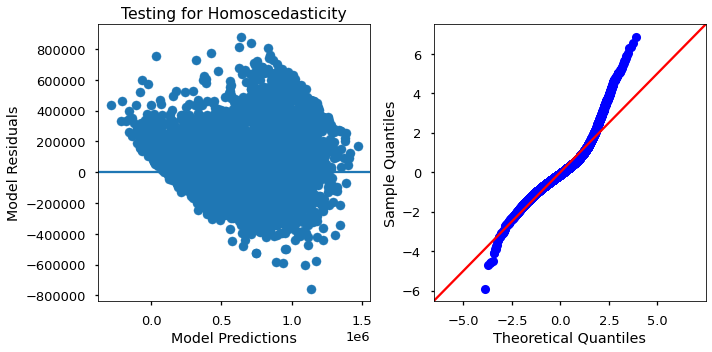

In [85]:
## Re-running model after removing 'has_bsmnt' and 'floors'" due to high p-value
categorical_features = ['was_renovated','waterfront', 'zipcode']

continuous_features = ['yrs_since_reno', 'bedrooms', 'bathrooms',
                       'condition','grade']

model_clean = create_model(data=df_clean, cont=continuous_features, cat=categorical_features)

In [86]:
# coeff_clean.sort_values(ascending=False)

In [87]:
# # Graphing mode paramnerters to show values
# coeff_clean = model_clean.params.sort_values(ascending=False)
# coeff_clean.plot(kind='barh');

# Recommendations based on Inferential Modeling

If a homeowner is interested in renovating their house, I would recommend the following improvements based on the high coefficients from my model.

* Add bathrooms
* Also consider adding bedrooms
* Use high-quality materials in renovations

While it is outside of the homeowner's ability to change, the zip code for a house's location also has a large impact on the price. A prospective buyer should keep the zip code of the area in mind to help determine the prices of the homes there.

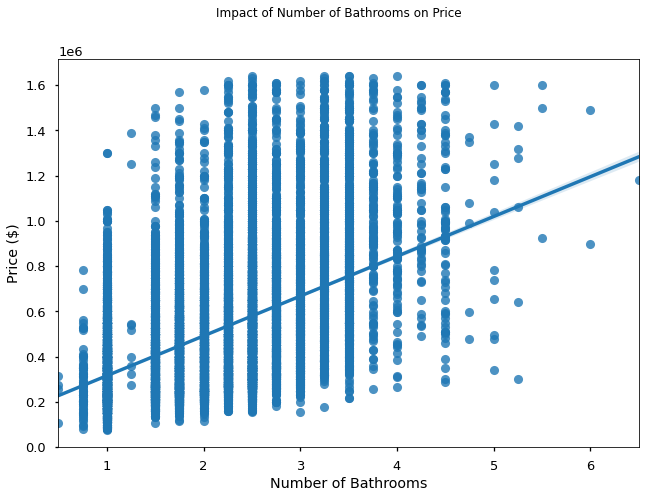

In [88]:
## Visualizing the impact of number of bathrooms on price
sns.regplot(data=df_clean, x="bathrooms", y='price')
plt.suptitle('Impact of Number of Bathrooms on Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price ($)');

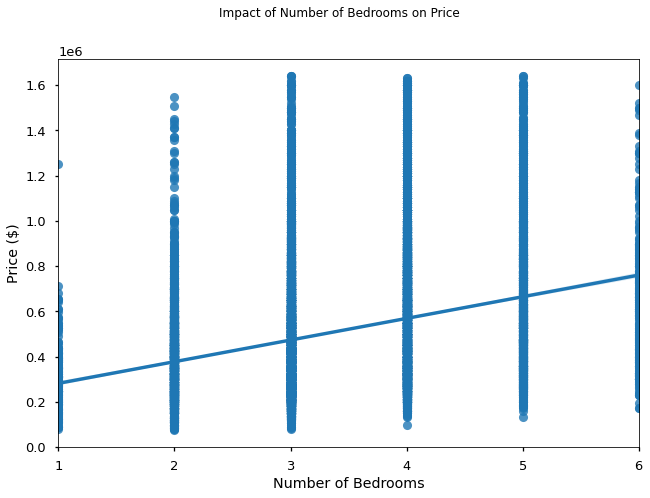

In [89]:
## Visualizing impact of number of bedrooms on price
sns.regplot(data=df_clean, x="bedrooms", y='price')
plt.suptitle('Impact of Number of Bedrooms on Price')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price ($)');

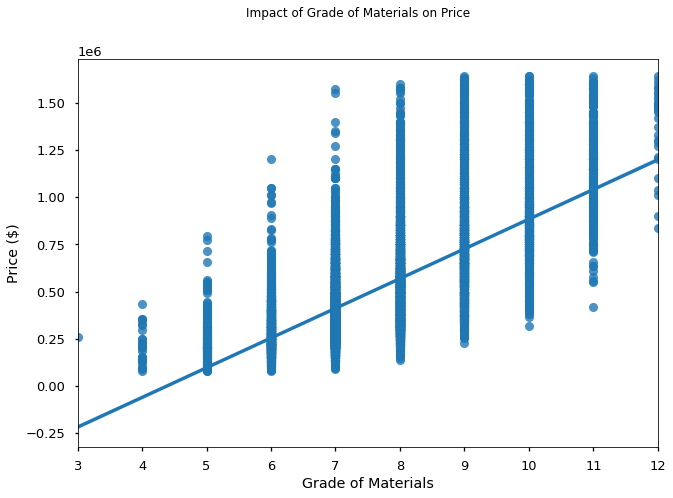

In [90]:
## Visualizing impact of the grade of construction materials on price
sns.regplot(data=df_clean, x="grade", y='price')
plt.suptitle('Impact of Grade of Materials on Price')
plt.xlabel('Grade of Materials')
plt.ylabel('Price ($)');

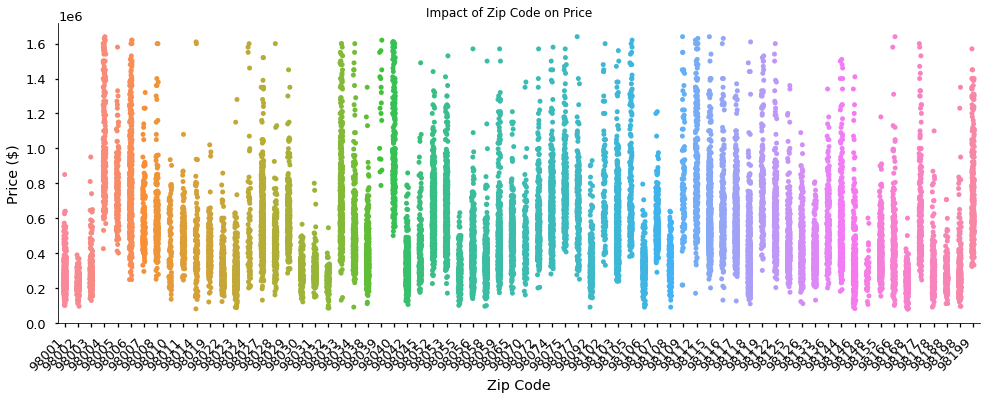

In [91]:
## Representing the diversity of prices based on zip codes

fg = sns.catplot(data=df_clean, x="zipcode", y='price', aspect=2.75, height=5)
fg.ax.set_xticklabels(fg.ax.get_xticklabels(), rotation=45, ha='right')
plt.suptitle('Impact of Zip Code on Price')
plt.xlabel('Zip Code')
plt.ylabel('Price ($)');

# **Model Testing for Predictions**

Now that I have a working model, I want to go ahead and test it to see how well it works. I will split the data in a 75/25 split into two groups; train a model on the 75%; and then compare it against the remaining 25%. 

**My goal is to have a Root Mean Squared Error (RMSE) less than 200,000.**

## ID Features, Target

First, I want to establish the features I want to use in my testing and my target variable (in this case, price).

In [94]:
## Save the features that we used previously - I will use these features 
## to fit my model.

X = df_clean[['was_renovated','waterfront', 'zipcode',
            'yrs_since_reno', 'bedrooms', 'bathrooms', 'condition','grade']].copy()

In [95]:
## Creating the y values by setting them equal to the 'price' values from the dataframe

y = df_clean['price'].copy()

In [96]:
## Verifying the two groups are of equal length

print(X.shape[0] == y.shape[0])

True


## Create Train/Test Split

Now I will split the data into the train/test groups. Then, I will run the first linear regression on the "train" data, then another regression on the "test" data.

In [97]:
## Establishing the train and test data before doing anything else

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=5)

In [98]:
## Using OneHotEncoder to create columns for the categorical variables.

## Create list of categorical variables
cat_feats = ['condition','grade', 'zipcode']

## Create the OHE without "drop='first" as it would throw an error in this case
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)

## Using OHE on our categorical variables for training (NOT testing)
train_ohe = ohe.fit_transform(X_train[cat_feats])
test_ohe = ohe.transform(X_test[cat_feats])

In [99]:
## Getting feature names from our list of categories
feat_col_name = ohe.get_feature_names(cat_feats)

In [100]:
## Creating dataframes from the results of our fit&transform and transform

train_ohe_df = pd.DataFrame(train_ohe, columns=feat_col_name, index=X_train.index)

test_ohe_df = pd.DataFrame(test_ohe, columns=feat_col_name, index=X_test.index)

In [101]:
## Reviewing one of the resulting dataframes
test_ohe_df

,condition_1,condition_2,condition_3,condition_4,condition_5,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6431000748,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7517500611,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1644500450,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2767704332,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9221400335,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898900280,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4154300296,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [102]:
## Reviewing the training dataset
X_train

,was_renovated,waterfront,zipcode,yrs_since_reno,bedrooms,bathrooms,condition,grade
id,,,,,,,,
5306100240,0,0.0,98133,0.0,3,2.00,3,7
3204400030,0,0.0,98092,0.0,4,2.25,3,8
3329530200,0,0.0,98001,0.0,3,2.00,3,7
65000210,0,0.0,98126,0.0,2,1.75,5,7
1898700050,0,0.0,98023,0.0,3,1.00,3,7
...,...,...,...,...,...,...,...,...
7852010290,0,0.0,98065,0.0,4,2.50,3,10
5151600195,0,0.0,98003,0.0,4,1.75,4,8
6762700452,0,0.0,98102,0.0,3,3.00,3,8


In [103]:
## Concatenating the two training dataframes after OHE
X_train_ohe = pd.concat([X_train.drop(cat_feats, axis=1), train_ohe_df], axis=1)

In [104]:
## Concatenating the two test dataframes after OHE
X_test_ohe = pd.concat([X_test.drop(cat_feats, axis=1), test_ohe_df], axis=1)
X_test_ohe

,was_renovated,waterfront,yrs_since_reno,bedrooms,bathrooms,condition_1,condition_2,condition_3,condition_4,condition_5,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6431000748,0,0.0,0.0,3,3.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7517500611,0,0.0,0.0,3,2.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1644500450,0,0.0,0.0,3,3.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2767704332,0,0.0,0.0,3,3.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9221400335,0,0.0,0.0,4,1.75,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898900280,0,0.0,0.0,4,3.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4154300296,0,0.0,0.0,3,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

## Fitting the Model

Now I will create the linear regression model.

In [105]:
## Instantiating the model and fitting it
lr = LinearRegression()

lr.fit(X_train_ohe, y_train)

LinearRegression()

In [106]:
## Checking the R^2 for train and test

train_r = lr.score(X_train_ohe, y_train)
print(f'R-Square value for training data is {round(train_r,3)}.')

test_r = lr.score(X_test_ohe, y_test)
print(f'R-Square value for test data is {round(test_r,3)}.')

## Getting model coefficients
train_coef = pd.Series(lr.coef_, index=X_train_ohe.columns)
train_coef['intercept'] = lr.intercept_

## Displaying resulting features and coefficients
train_coef.sort_values(ascending=False)#.plot(kind='barh');

R-Square value for training data is 0.784.
R-Square value for test data is 0.77.


condition_5      2.822785e+16
condition_4      2.822785e+16
condition_3      2.822785e+16
condition_2      2.822785e+16
condition_1      2.822785e+16
                     ...     
zipcode_98032   -8.680871e+14
zipcode_98003   -8.680871e+14
zipcode_98092   -8.680871e+14
zipcode_98023   -8.680871e+14
intercept       -2.897246e+16
Length: 91, dtype: float64

In [107]:
## Determining predictions for training data

y_train_pred = lr.predict(X_train_ohe)

## Determining predictions for test data

y_test_pred = lr.predict(X_test_ohe)

## Evaluate Performance

Let's see how it performed against the test dataset!

In [108]:
## Calculating scores for training model

train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Evaluating performance of training data.')
print()
print(f'Mean Absolute Error: {train_mae:,.2f}')
print(f'Mean Squared Error:  {train_mse:,.2f}')
print()
print(f'Root Mean Squared Error: {train_rmse:,.2f}')
train_r = lr.score(X_train_ohe, y_train)
print(f'R-Square value for training data is {round(train_r,2)}.')

Evaluating performance of training data.

Mean Absolute Error: 85,123.02
Mean Squared Error:  14,720,858,044.10

Root Mean Squared Error: 121,329.54
R-Square value for training data is 0.78.


In [109]:
## Calculating scores for test model

test_mae = metrics.mean_absolute_error(y_test, y_test_pred)
test_mse = metrics.mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print(f'Mean Absolute Error: {test_mae:,.2f}')
print(f'Mean Squared Error: {test_mse:,.2f}')
print()
print(f'Root Mean Squared Error: {test_rmse:,.2f}')
test_r = lr.score(X_test_ohe, y_test)
print(f'R-Square value for test data is {round(test_r,2)}.')

Mean Absolute Error: 85,609.29
Mean Squared Error: 14,832,622,910.86

Root Mean Squared Error: 121,789.26
R-Square value for test data is 0.77.


## Comparing Results

In [110]:
## Calculating difference between RMSE(Training) and RMSE(Test)

print('Our RMSE values for each set:')
print(f'Train RMSE: {train_rmse:,.2f}')
print(f'Test RMSE: {test_rmse:,.2f}')

diff = train_rmse - test_rmse

print()
print(f'The difference in RMSE between our training and test sets is {diff:,.2f}.')

Our RMSE values for each set:
Train RMSE: 121,329.54
Test RMSE: 121,789.26

The difference in RMSE between our training and test sets is -459.71.


## Testing Assumptions

In [111]:
## Determining residuals
residuals = (y_test - y_test_pred)
residuals

id
6431000748   -257560.0
7517500611     90488.0
1644500450     43316.0
2767704332   -165792.0
9221400335    -78012.0
                ...   
1898900280     -5028.0
4154300296    -92668.0
1994200024     37084.0
7625700935    -62756.0
3876200060    -77208.0
Name: price, Length: 5285, dtype: float64

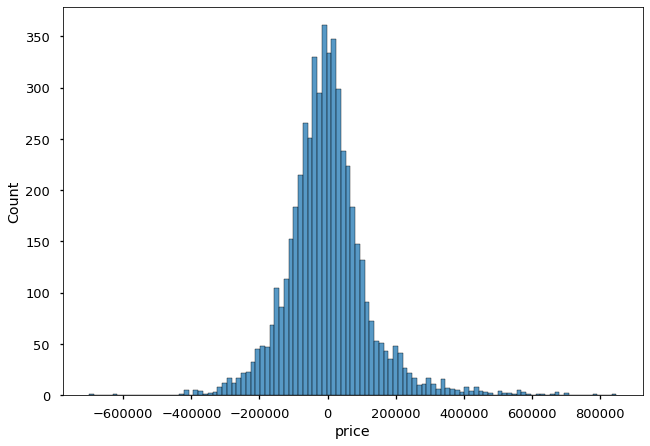

In [112]:
## Plotting to test for normality
sns.histplot(data=residuals);

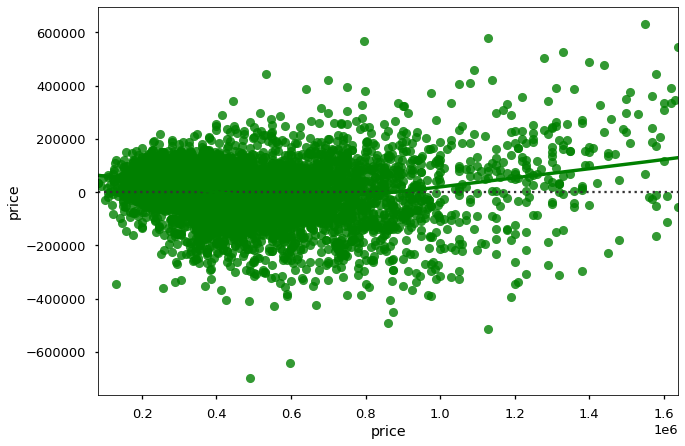

In [113]:
## Checking the homoscedasticity of the new model
sns.residplot(x=y_test, y=residuals, lowess=True, color="g");

### Interpretation of Model Results

The model does a great job of explaining the variance between our selected features, with an r-squared value of .79/1.

The RMSE for both the training and test sets are below our target of 200,000! Additionally, the difference between the two is within an acceptable range.

The assumption tests confirm the assumptions that our residuals would be normally distributed and homoscedastic.

## Recursive Feature Elimination

I have a good model created above, but I'd like to see if changing the features would have an impact for me.

**I will use the Recursive Feature Elimination method with Cross Validation to determine another selection of features.**

In [114]:
## Creating the settings for the selector
selector = RFECV(estimator=lr, step=2, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

In [115]:
## Running it on our training data
selector.fit(X_train_ohe, y_train)

Fitting estimator with 90 features.
Fitting estimator with 88 features.
Fitting estimator with 86 features.
Fitting estimator with 84 features.
Fitting estimator with 82 features.
Fitting estimator with 80 features.
Fitting estimator with 78 features.
Fitting estimator with 76 features.
Fitting estimator with 74 features.
Fitting estimator with 72 features.
Fitting estimator with 70 features.
Fitting estimator with 68 features.
Fitting estimator with 66 features.
Fitting estimator with 64 features.
Fitting estimator with 62 features.
Fitting estimator with 60 features.
Fitting estimator with 58 features.
Fitting estimator with 56 features.
Fitting estimator with 54 features.
Fitting estimator with 52 features.
Fitting estimator with 50 features.
Fitting estimator with 48 features.
Fitting estimator with 46 features.
Fitting estimator with 44 features.
Fitting estimator with 42 features.
Fitting estimator with 40 features.
Fitting estimator with 38 features.
Fitting estimator with 36 fe

RFECV(cv=3, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_squared_error', step=2, verbose=1)

In [116]:
## Dividing the data into two separate variables for inspection
selected_columns = X_train_ohe.columns[selector.get_support()]
removed_columns = X_train_ohe.columns[~selector.get_support()]

In [117]:
## Inspecting the columns with the greatest impact according to the RSECV method
list(selected_columns.values)

['condition_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12']

In [118]:
## Testing the new list of columns

## Instantiating a new regression model
lr_rfe = LinearRegression()

## Fitting the model to the new data
lr_rfe.fit(X_train_ohe[selected_columns], y_train)

# Using the model to create new predictions
y_rfe = lr_rfe.predict(X_train_ohe[selected_columns])

# Determining RMSE for new list of columns and TRAIN data
trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))

print(f'Training Root Mean Squared Error: {trainRFE_rmse:,.2f}')

# Determining RMSE for new list of columns and TEST data
y_pred_rfe = lr_rfe.predict(X_test_ohe[selected_columns])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print(f'Testing Root Mean Squared Error: {testRFE_rmse:,.2f}')

diff2 = trainRFE_rmse - testRFE_rmse
print()
print(f'The difference in RMSE between our training and test sets is {diff2:,.2f}.')

Training Root Mean Squared Error: 185,155.83
Testing Root Mean Squared Error: 182,372.46

The difference in RMSE between our training and test sets is 2,783.37.


In [119]:
test_rsq = lr_rfe.score(X_test_ohe[selected_columns], y_test)
print(f'R-Square value for testing data after RFECV is {round(test_rsq,2)}.')

R-Square value for testing data after RFECV is 0.48.


### Interpretation of Results of RFEVC

---
**Comparing RMSEs from original model to RFECV:**

* **Pre-RFECV model results:**
   * The R^2 value for both training and testing data was .79 (significant as it is over the .70 threshold).
   * *Our RMSE values for each set:*
        * Train RMSE: 117,679.79
        * Test RMSE: 122,263.56
    * The difference in RMSE between our training and test sets is **-4,583.77**.


 * **Post-RFECV model results:**
     * The R^2 value for the test data is .48 (.31 lower than other model, and far below threshold).
     * *Our RMSE values for each set:*
         * Training Root Mean Squared Error: 182,158.41
         * Testing Root Mean Squared Error: 191,360.88
     * The difference in RMSE between our training and test sets is **-9,202.47**.

---

**Final Analysis of RFE method:** The RFE results produced a large decrease in model perfomance as determined by the lower R^2 and lower RMSE values. I will continue using the first model for future predictions.

---

# **Model Testing - Original Data**

The model produced above was based on data from which we removed any outliers. I am re-running the tests to determine if there is any difference in the results. 

**My goal is to have a Root Mean Squared Error (RMSE) less than 200,000.**

## ID Features, Target

In [120]:
## Saving the features that I used for inferential modeling - I will use these features 
## to fit my model.

X = df[['was_renovated','waterfront', 'zipcode',
            'yrs_since_reno', 'bedrooms', 'bathrooms', 'condition','grade']].copy()

In [121]:
## Creating the y values by setting them equal to the 'price' values from the dataframe

y = df['price'].copy()

In [122]:
## Verifying the two groups are of equal length

print(X.shape[0] == y.shape[0])

True


## Create Train/Test Split

Now I will split the data into the train/test groups. Then, I will run the first linear regression on the "train" data, then another regression on the "test" data.

In [123]:
## Establishing the train and test data before doing anything else

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=5)

In [124]:
## Using OneHotEncoder to create columns for the categorical variables.

## Create list of categorical variables
cat_feats = ['condition','grade', 'zipcode']

## Create the OHE without "drop='first" as it would throw an error in this case
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)

## Using OHE on our categorical variables for training (NOT testing)
train_ohe = ohe.fit_transform(X_train[cat_feats])
test_ohe = ohe.transform(X_test[cat_feats])

In [125]:
## Getting feature names from our list of categories
feat_col_name = ohe.get_feature_names(cat_feats)

In [126]:
## Creating dataframes from the results of our fit&transform and transform

train_ohe_df = pd.DataFrame(train_ohe, columns=feat_col_name, index=X_train.index)

test_ohe_df = pd.DataFrame(test_ohe, columns=feat_col_name, index=X_test.index)

In [127]:
## Reviewing one of the resulting dataframes
test_ohe_df

,condition_1,condition_2,condition_3,condition_4,condition_5,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
104560280,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1725059316,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3861470120,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7853361310,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3834000004,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475200330,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8857600360,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [128]:
X_train

,was_renovated,waterfront,zipcode,yrs_since_reno,bedrooms,bathrooms,condition,grade
id,,,,,,,,
3760100100,0,0.0,98034,0.0,5,2.75,3,7
3754501205,0,0.0,98034,0.0,3,2.50,3,11
1423900580,0,0.0,98058,0.0,3,1.75,3,7
7853301930,0,0.0,98065,0.0,3,2.50,3,7
913000340,1,0.0,98116,23.0,1,1.00,1,6
...,...,...,...,...,...,...,...,...
9407000840,0,0.0,98045,0.0,3,1.75,3,7
7852020300,0,0.0,98065,0.0,3,2.50,3,8
7904700146,0,0.0,98116,0.0,2,1.50,3,7


In [129]:
## Combining the training dataframes after performing OHE
X_train_ohe = pd.concat([X_train.drop(cat_feats, axis=1), train_ohe_df], axis=1)

In [130]:
## Combining the testing dataframes after performing OHE
X_test_ohe = pd.concat([X_test.drop(cat_feats, axis=1), test_ohe_df], axis=1)
X_test_ohe

,was_renovated,waterfront,yrs_since_reno,bedrooms,bathrooms,condition_1,condition_2,condition_3,condition_4,condition_5,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
104560280,0,0.0,0.0,4,3.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1725059316,0,0.0,0.0,4,4.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3861470120,0,0.0,0.0,4,2.75,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7853361310,0,0.0,0.0,4,2.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3834000004,0,0.0,0.0,2,1.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475200330,0,0.0,0.0,3,2.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8857600360,0,0.0,0.0,3,1.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## Fitting the Model

In [131]:
## Instantiating the model and fitting it
lr = LinearRegression()

lr.fit(X_train_ohe, y_train)

LinearRegression()

In [132]:
## Checking the R^2 for train and test

train_r = lr.score(X_train_ohe, y_train)
print(f'R-Square value for training data is {round(train_r,3)}.')

test_r = lr.score(X_test_ohe, y_test)
print(f'R-Square value for test data is {round(test_r,3)}.')

## Getting model coefficients
train_coef = pd.Series(lr.coef_, index=X_train_ohe.columns)
train_coef['intercept'] = lr.intercept_

## Displaying resulting features and coefficients
train_coef.sort_values(ascending=False)[:11]#.plot(kind='barh');

R-Square value for training data is 0.779.
R-Square value for test data is 0.789.


intercept    1.301300e+15
grade_13     2.757647e+13
grade_12     2.757647e+13
grade_11     2.757647e+13
grade_10     2.757647e+13
grade_9      2.757647e+13
grade_8      2.757647e+13
grade_3      2.757647e+13
grade_4      2.757647e+13
grade_7      2.757647e+13
grade_6      2.757647e+13
dtype: float64

In [133]:
## Determining predictions for training data

y_train_pred = lr.predict(X_train_ohe)


## Determining predictions for test data

y_test_pred = lr.predict(X_test_ohe)


## Evaluate Performance

In [134]:
## Calculating scores for training model

train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Evaluating performance of training data.')
print()
print(f'Mean Absolute Error: {train_mae:,.2f}')
print(f'Mean Squared Error:  {train_mse:,.2f}')
print()
print(f'Root Mean Squared Error: {train_rmse:,.2f}')
train_r = lr.score(X_train_ohe, y_train)
print(f'R-Square value for training data is {round(train_r,2)}.')

Evaluating performance of training data.

Mean Absolute Error: 102,024.47
Mean Squared Error:  29,566,813,960.99

Root Mean Squared Error: 171,950.03
R-Square value for training data is 0.78.


In [135]:
## Calculating scores for test model

test_mae = metrics.mean_absolute_error(y_test, y_test_pred)
test_mse = metrics.mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print(f'Mean Absolute Error: {test_mae:,.2f}')
print(f'Mean Squared Error: {test_mse:,.2f}')
print()
print(f'Root Mean Squared Error: {test_rmse:,.2f}')
test_r = lr.score(X_test_ohe, y_test)
print(f'R-Square value for test data is {round(test_r,2)}.')

Mean Absolute Error: 103,731.48
Mean Squared Error: 29,127,394,843.73

Root Mean Squared Error: 170,667.50
R-Square value for test data is 0.79.


## Comparing Results

In [136]:
## Calculating difference between RMSE(Training) and RMSE(Test)

print('Our RMSE values for each set:')
print(f'Train RMSE: {train_rmse:,.2f}')
print(f'Test RMSE: {test_rmse:,.2f}')

diff = train_rmse - test_rmse

print()
print(f'The difference in RMSE between our training and test sets is {diff:,.2f}.')

Our RMSE values for each set:
Train RMSE: 171,950.03
Test RMSE: 170,667.50

The difference in RMSE between our training and test sets is 1,282.54.


## Testing Assumptions

In [137]:
## Determining residuals
residuals = (y_test - y_test_pred)
residuals

id
104560280       -6520.00
1725059316   -1369689.50
3861470120    -253956.00
7853361310     -67091.25
3834000004      -5654.50
                 ...    
2475200330      78756.50
8857600360     -24120.25
7524950210     176922.50
9284801165     -82283.75
2207100165      -4106.00
Name: price, Length: 5400, dtype: float64

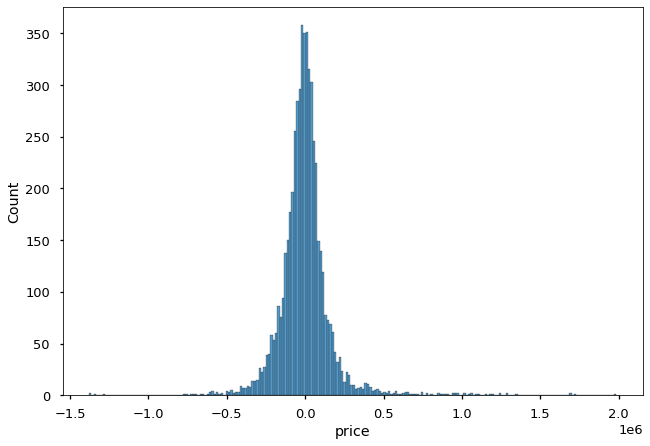

In [138]:
## Plotting to test for normality
sns.histplot(data=residuals);

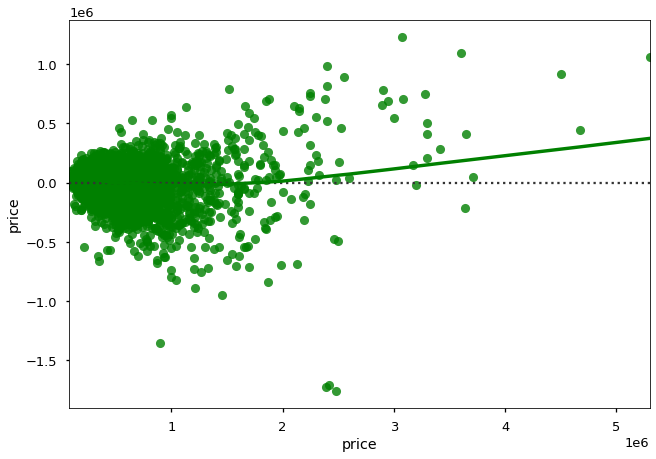

In [139]:
## Checking the homoscedasticity of the new model
sns.residplot(x=y_test, y=residuals, lowess=True, color="g");

### Interpretation of Model Results

The model continues to do a job of explaining the variance between our selected features, with an r-squared value of .79/1.

The RMSE for both the training and test sets are below our target of 200,000, but higher than our model without the outliers. The difference between the two RMSEs did increase, indicating area for improvement.

The assumption tests confirm the assumptions that our residuals would be normally distributed and homoscedastic.

## Recursive Feature Elimination

The model using the original data performed worse in terms of RMSE, but maintained the R^2 value of .79.

Let's see if the RFECV has any impact this time.

In [140]:
## Creating the settings for the selector
selector = RFECV(estimator=lr, step=2, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

In [141]:
## Running it on our training data
selector.fit(X_train_ohe, y_train)

Fitting estimator with 91 features.
Fitting estimator with 89 features.
Fitting estimator with 87 features.
Fitting estimator with 85 features.
Fitting estimator with 83 features.
Fitting estimator with 81 features.


RFECV(cv=3, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_squared_error', step=2, verbose=1)

In [142]:
## Dividing the data into two separate variables for inspection
selected_columns = X_train_ohe.columns[selector.get_support()]
removed_columns = X_train_ohe.columns[~selector.get_support()]

In [143]:
## Inspecting the columns with the greatest impact according to the RSECV method
list(selected_columns.values)

['grade_3',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'zipcode_98001',
 'zipcode_98002',
 'zipcode_98003',
 'zipcode_98004',
 'zipcode_98005',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98022',
 'zipcode_98023',
 'zipcode_98024',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98030',
 'zipcode_98031',
 'zipcode_98032',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98039',
 'zipcode_98040',
 'zipcode_98042',
 'zipcode_98045',
 'zipcode_98052',
 'zipcode_98053',
 'zipcode_98055',
 'zipcode_98056',
 'zipcode_98058',
 'zipcode_98059',
 'zipcode_98065',
 'zipcode_98070',
 'zipcode_98072',
 'zipcode_98074',
 'zipcode_98075',
 'zipcode_98077',
 'zipcode_98092',
 'zipcode_98102',
 'zipcode_98103',
 'zipcode_98105',
 'zipcode_98106',
 'zipcode_98107',
 'zipcode_98108',
 'zipcode_98109',
 'zipcode_98112',
 'zipc

In [144]:
## Testing the new list of columns

## Instantiating a new regression model
lr_rfe = LinearRegression()

## Fitting the model to the new data
lr_rfe.fit(X_train_ohe[selected_columns], y_train)

# Using the model to create new predictions
y_rfe = lr_rfe.predict(X_train_ohe[selected_columns])

# Determining RMSE for new list of columns and TRAIN data
trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))

print(f'Training Root Mean Squared Error: {trainRFE_rmse:,.2f}')

# Determining RMSE for new list of columns and TEST data
y_pred_rfe = lr_rfe.predict(X_test_ohe[selected_columns])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print(f'Testing Root Mean Squared Error: {testRFE_rmse:,.2f}')

diff2 = trainRFE_rmse - testRFE_rmse
print()
print(f'The difference in RMSE between our training and test sets is {diff2:,.2f}.')

Training Root Mean Squared Error: 195,518.85
Testing Root Mean Squared Error: 203,717.56

The difference in RMSE between our training and test sets is -8,198.71.


In [145]:
test_rsq = lr_rfe.score(X_test_ohe[selected_columns], y_test)
print(f'R-Square value for testing data after RFECV is {round(test_rsq,2)}.')

R-Square value for testing data after RFECV is 0.7.


---
**Comparing RMSEs from original to RFECV:**

* **Pre-RFECV model results:**
   * The R^2 value for both training and testing data was .79 (significant as it is over the .70 threshold).
   * *Our RMSE values for each set:*
        * Train RMSE: 117,679.79
        * Test RMSE: 122,263.56
    * The difference in RMSE between our training and test sets is **-4,583.77**.


 * **Post-RFECV model results:**
     * The R^2 value for the test data is .48 (.31 lower than other model, and far below threshold).
     * *Our RMSE values for each set:*
         * Training Root Mean Squared Error: 182,158.41
         * Testing Root Mean Squared Error: 191,360.88
     * The difference in RMSE between our training and test sets is **-9,202.47**.

---

**Final Analysis of RFE method:** The RFE results produced a large decrease in model perfomance as determined by the lower R^2 and lower RMSE values. I will continue with the first model for future predictions.

---

# **Pickling the Model for Reuse**

In [147]:
## Setting coefficients and target
X = df[['was_renovated','waterfront', 'zipcode',
            'yrs_since_reno', 'bedrooms', 'bathrooms', 'condition','grade']].copy()
y = df['price'].copy()

In [149]:
## Create list of categorical variables
cat_feats = ['condition','grade', 'zipcode']

## Create the OHE without "drop='first" as it would throw an error in this case
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)

## Using OHE on our categorical variables for training (NOT testing)
final_ohe = ohe.fit_transform(X[cat_feats])

In [150]:
## Getting feature names from our list of categories
feat_col_name = ohe.get_feature_names(cat_feats)

In [151]:
## Creating DF of final results
penultimate_ohe_df = pd.DataFrame(final_ohe, columns=feat_col_name, index=X.index)

In [152]:
## Updating final DF
final_ohe_df = pd.concat([X.drop(cat_feats, axis=1), penultimate_ohe_df], axis=1)

In [153]:
## Instantiating and fitting the regression
lr_final = LinearRegression()

lr_final = lr_final.fit(final_ohe_df, y)

In [154]:
# Generating predictions
final_pred = lr_final.predict(final_ohe_df)

In [155]:
## Confirming predictions work
display(final_pred)

array([190368., 527984., 232768., ..., 363440., 486896., 363440.])

In [156]:
# Saving model to .pickle file
import pickle

pickle_out = open("final_model.pickle","wb")
pickle.dump(lr_final, pickle_out)
pickle_out.close()

In [157]:
# final_ohe_df.columns.to_list()